# testing expanding the utils and evaluating the different resolutions

In [1]:
##this file contains an evaluation helper class which will contain the data loader and the model, and enables quick evaluation of the model on the test set
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
# from src.tasks.encoders import EnformerEncoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
import src.dataloaders.datasets.enformer_dataset as enformer_dataset
import yaml
from omegaconf import OmegaConf
import os
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
import argparse
import itertools

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")

base_path: /data1/lesliec/sarthak/


In [2]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/00-16-16-651049/checkpoints/06-val_loss=0.22732.ckpt'
model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
cfg = OmegaConf.create(cfg)
cfg = OmegaConf.to_container(cfg, resolve=True)
cfg

{'train': {'seed': 2222,
  'interval': 'epoch',
  'monitor': 'val/loss',
  'mode': 'min',
  'ema': 0.0,
  'test': True,
  'debug': False,
  'ignore_warnings': False,
  'optimizer_param_grouping': {'bias_weight_decay': False,
   'normalization_weight_decay': False},
  'state': {'mode': None, 'n_context': 0, 'n_context_eval': 0},
  'ckpt': 'checkpoints/last.ckpt',
  'disable_dataset': False,
  'validate_at_start': False,
  'pretrained_model_path': None,
  'pretrained_model_strict_load': False,
  'pretrained_model_state_hook': {'_name_': 'load_backbone',
   'freeze_backbone': False,
   'ignore_head': True,
   'add_embeddings': False,
   'ignore_embeddings': False},
  'post_init_hook': {'_name_': None},
  'layer_decay': {'_name_': None, 'decay': 0.7},
  'gpu_mem': 82,
  'global_batch_size': 1,
  'pretrained_safetensors_model_path': None},
 'wandb': {'project': 'dna',
  'group': 'enformer',
  'job_type': 'training',
  'mode': 'online',
  'name': 'Enformer_cnn_1bp',
  'save_dir': '.',
  'id'

In [3]:
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
split = 'test'
dataset_args = cfg['dataset']
dataset_args

{'_name_': 'EnformerLoader',
 'bed_file': None,
 'fasta_file': None,
 'dataset_name': 'EnformerLoader',
 'tokenizer_name': 'char',
 'cache_dir': None,
 'max_length': 196608,
 'add_eos': False,
 'batch_size': 1,
 'batch_size_eval': 2,
 'num_workers': 1,
 'shuffle': True,
 'pin_memory': True,
 '__train_len': 5087,
 '__l_max': 196608,
 'max_length_val': 196608,
 'max_length_test': 196608,
 'pad_max_length': None,
 'rc_aug': False,
 'd_output': 4675,
 'use_fixed_len_val': False,
 'replace_N_token': False,
 'pad_interval': False,
 'return_CAGE': False,
 'kmer_len': None,
 'mlm': False,
 'one_hot': True,
 'pool': 1,
 'cell_type': 'DNase',
 'data_path': '/data1/lesliec/sarthak/data/borzoi/outputs/hg38/labels.zarr'}

In [4]:
#ahh can use args and kwargs if we remove the unnecessary bloat
#remnove __name__ and a bunch of others, then direclty input all the rest!!
#just manually determine what we actually want to input...
import inspect
# enformer_dataset.EnformerDataset.__init__(self, **dataset_args)
sig = inspect.signature(enformer_dataset.EnformerDataset.__init__)
sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
sig

{'split': <Parameter "split">,
 'max_length': <Parameter "max_length">,
 'pad_max_length': <Parameter "pad_max_length=None">,
 'tokenizer': <Parameter "tokenizer=None">,
 'tokenizer_name': <Parameter "tokenizer_name=None">,
 'add_eos': <Parameter "add_eos=False">,
 'use_padding': <Parameter "use_padding=True">,
 'rc_aug': <Parameter "rc_aug=False">,
 'return_augs': <Parameter "return_augs=False">,
 'replace_N_token': <Parameter "replace_N_token=False">,
 'pad_interval': <Parameter "pad_interval=False">,
 'uppercase': <Parameter "uppercase=True">,
 'd_output': <Parameter "d_output=None">,
 'data_path': <Parameter "data_path=None">,
 'return_CAGE': <Parameter "return_CAGE=False">,
 'load_into_memory': <Parameter "load_into_memory=None">,
 'cell_type': <Parameter "cell_type=None">,
 'kmer_len': <Parameter "kmer_len=None">,
 'return_target': <Parameter "return_target=True">,
 'one_hot': <Parameter "one_hot=False">,
 'pool': <Parameter "pool=1">,
 'pool_type': <Parameter "pool_type='mean'">

In [5]:
to_remove = []
for k, v in dataset_args.items():
    if k not in sig:
        # del dataset_args[k]
        to_remove.append(k)
for k in to_remove:
    del dataset_args[k]
dataset_args

{'tokenizer_name': 'char',
 'max_length': 196608,
 'add_eos': False,
 'pad_max_length': None,
 'rc_aug': False,
 'd_output': 4675,
 'replace_N_token': False,
 'pad_interval': False,
 'return_CAGE': False,
 'kmer_len': None,
 'one_hot': True,
 'pool': 1,
 'cell_type': 'DNase',
 'data_path': '/data1/lesliec/sarthak/data/borzoi/outputs/hg38/labels.zarr'}

In [6]:
#amend it to take this, that way generalizes!! Make sure there's no issues!!
#and also dictionary inputs are not ordered in function calls, so ok to be random here!
#what's important is to make sure manually we have everything
#the final thing we need to do is add split

dataset_args['split'] = split

In [7]:
#now let's try running this into the dataset
dataset = enformer_dataset.EnformerDataset(**dataset_args)

In [8]:
#now let's verify this works
len(dataset)

1937

In [9]:
out = dataset[0]
print(out[0].shape, out[1].shape)

torch.Size([4, 196608]) torch.Size([114688, 674])


# now modified myy eval utils to take this into account!

In [1]:
#now we can test the evals class with this
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
import evals.evals_utils_enformer as e
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/00-16-16-651049/checkpoints/06-val_loss=0.22732.ckpt'
evals = e.Evals(ckpt_path)
out = evals.dataset[0]
print(out[0].shape, out[1].shape)

base_path: /data1/lesliec/sarthak/
674
torch.Size([4, 196608]) torch.Size([114688, 674])


In [2]:
evals.device

device(type='cuda')

In [3]:
#let's try evaluating it?
out = evals(0)
out.shape

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [4]:
evals.encoder

IdentityNet()

In [5]:
#ok maybe not used to one hot data?
data = evals.dataset[0][0]
data.shape

torch.Size([4, 196608])

In [7]:
#oh, here's the issue, my embedding layer doesn't take into account the one hot encoding I think
evals.backbone

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): Sequential(
          (0): Conv1d(4, 128, kernel_size=(15,), stride=(1,), padding=same)
          (1): ReLU()
          (2): Conv1d(128, 256, kernel_size=(15,), stride=(1,), padding=same)
          (3): ReLU()
          (4): Transpose()
        )
      )
      (layers): ModuleList(
        (0-15): 16 x Block(
          (mixer): BiMambaWrapper(
            (mamba_fwd): Mamba(
              (in_proj): Linear(in_features=256, out_features=1024, bias=False)
              (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
              (act): SiLU()
              (x_proj): Linear(in_features=512, out_features=48, bias=False)
              (dt_proj): Linear(in_features=16, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=256, bias=False)
            )
            (m

In [9]:
#wait this has the convolutions...
data = data.cuda().unsqueeze(0)
x,_ = evals.backbone(data)
x.shape

torch.Size([1, 196608, 256])

In [10]:
#wait this goes through just fine??
#must be the encoder
x,_ = evals.encoder(data)
x.shape

torch.Size([1, 4, 196608])

In [11]:
data.shape

torch.Size([1, 4, 196608])

In [13]:
#is that not correct??
x,_ = evals.backbone(data)
x.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacty of 79.15 GiB of which 137.25 MiB is free. Including non-PyTorch memory, this process has 79.00 GiB memory in use. Of the allocated memory 78.32 GiB is allocated by PyTorch, and 192.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
#Hmm, let's restart and make sure we do it properly and see why this is an issue

import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
import evals.evals_utils_enformer as e
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/00-16-16-651049/checkpoints/06-val_loss=0.22732.ckpt'
evals = e.Evals(ckpt_path)



base_path: /data1/lesliec/sarthak/
674


In [2]:
data = evals.dataset[0][0]
inp = data.cuda().unsqueeze(0)
inp.shape

torch.Size([1, 4, 196608])

In [3]:
data.dim()

2

In [2]:
#oh the issue is that our data dim is 2 if it's one hot, have to make sure that it's batch size...
#ok we edited it, should work now
out = evals(0)
out.shape

torch.Size([1, 114688, 674])

In [3]:
inp,true = evals.dataset[0]
inp.shape, true.shape

(torch.Size([4, 196608]), torch.Size([114688, 674]))

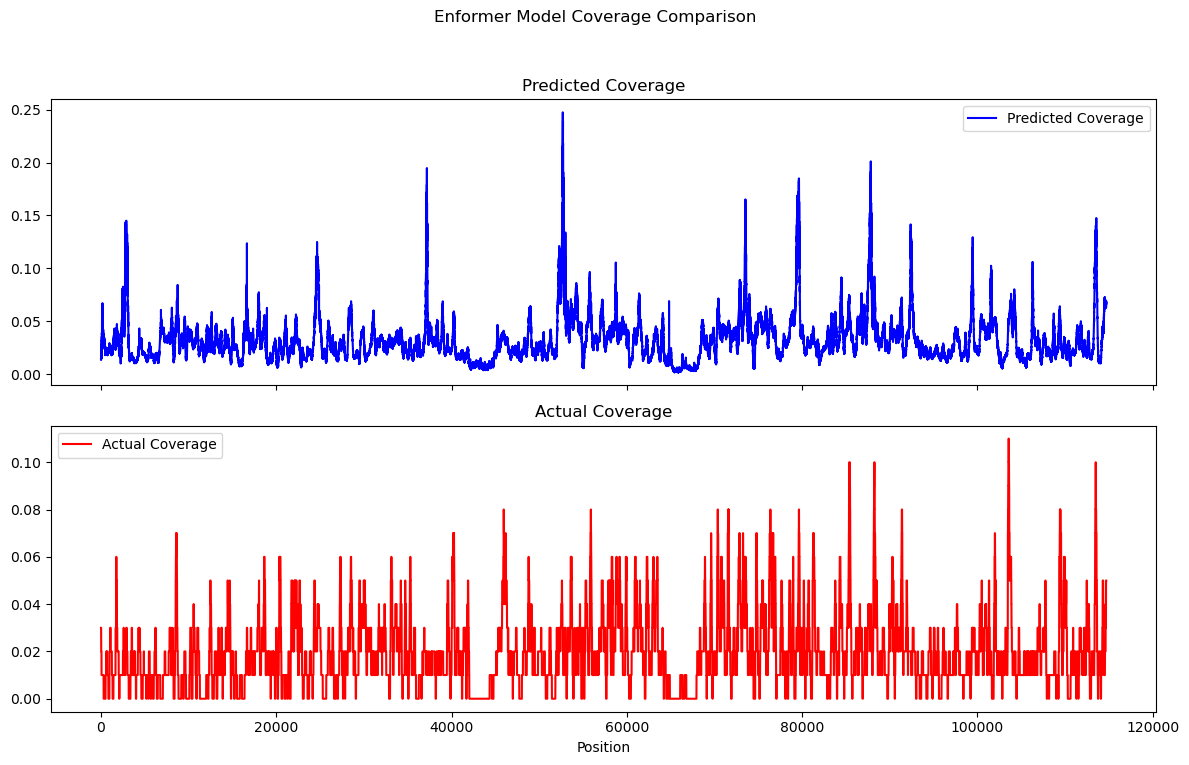

(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'Predicted Coverage'}>,
  <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>))

In [2]:
#ok at least the things match!
evals.plot_track(0)

In [3]:
#let's find a value that's large
for i in range(100):
    seq,label = evals.dataset[i]
    if label[:,121].max() > 10:
        print(i)
        break
        

3


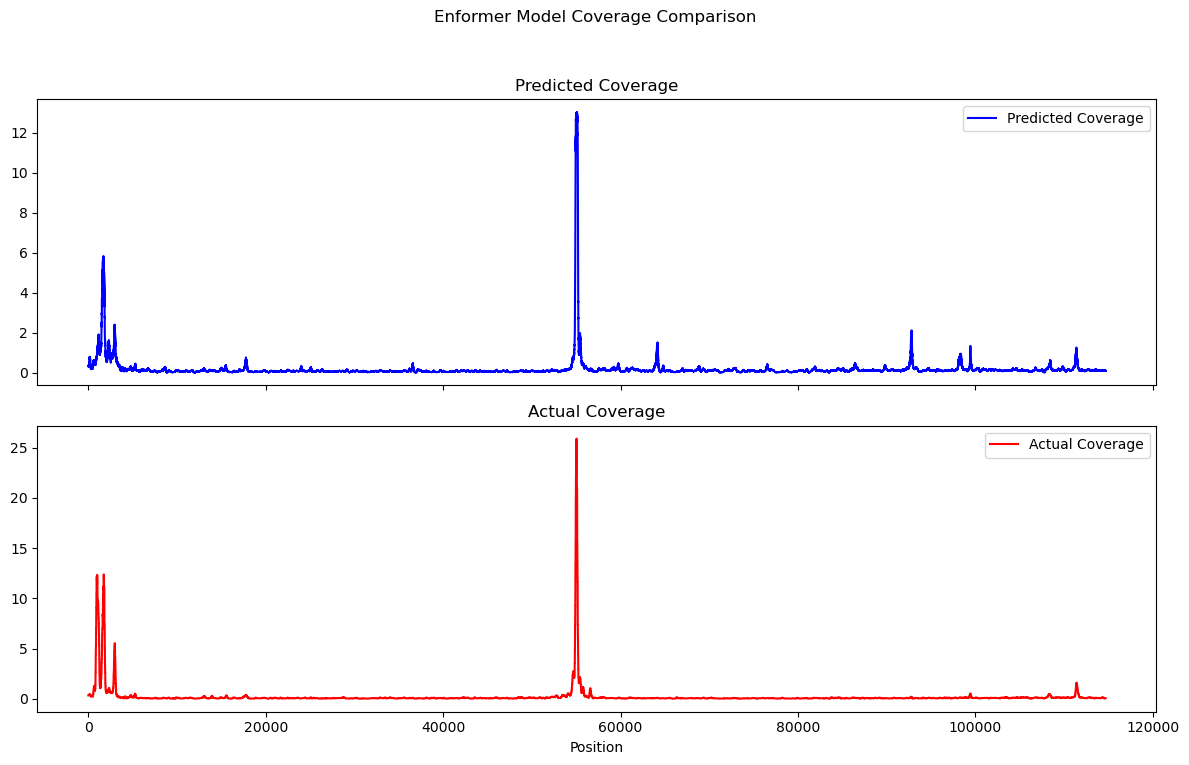

(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'Predicted Coverage'}>,
  <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>))

In [4]:
evals.plot_track(3)

In [5]:
#now check it pooled at 128 bp resolution
seq,label = evals.dataset[3]
out = evals(3)
print(out.shape, label.shape)

torch.Size([1, 114688, 674]) torch.Size([114688, 674])


In [6]:
#let's now average over 128 bp
out = out.squeeze(0)
print(out.shape, label.shape)

torch.Size([114688, 674]) torch.Size([114688, 674])


In [12]:
targets = label
targets = targets.view(targets.size(0) // 128, 128, targets.size(1))
print(targets.shape)
targets = targets.mean(dim=1).cpu().numpy()
print(targets.shape)

torch.Size([896, 128, 674])
(896, 674)


In [13]:
#now let's do this for the out
out_128 = out.view(out.size(0) // 128, 128, out.size(1))
print(out_128.shape)
out_128 = out_128.mean(dim=1).cpu().detach().numpy()
print(out_128.shape)

torch.Size([896, 128, 674])
(896, 674)


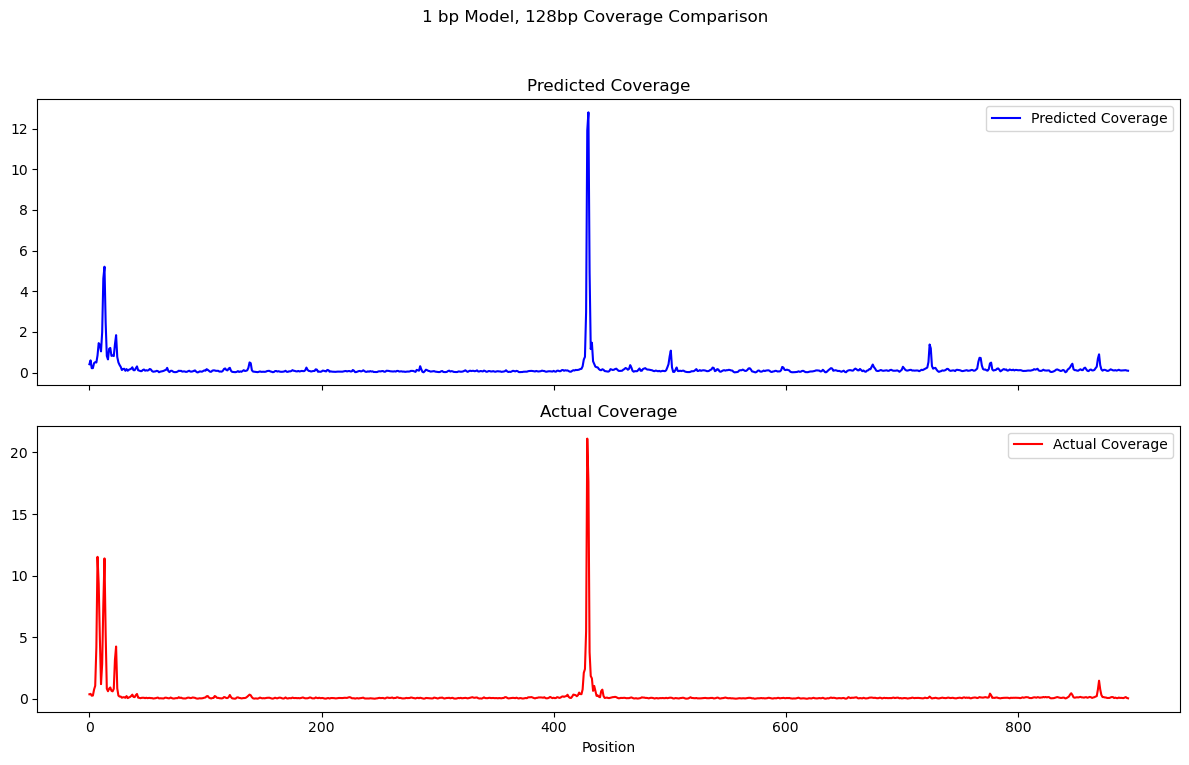

In [14]:
#now let's plot this
import matplotlib.pyplot as plt
track = 121
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
ax1.plot(out_128[:, track], label='Predicted Coverage', color='b')
ax1.set_title('Predicted Coverage')
ax1.legend()

ax2.plot(targets[:, track], label='Actual Coverage', color='r')
ax2.set_title('Actual Coverage')
ax2.legend()

ax2.set_xlabel('Position')
fig.suptitle('1 bp Model, 128bp Coverage Comparison')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

674


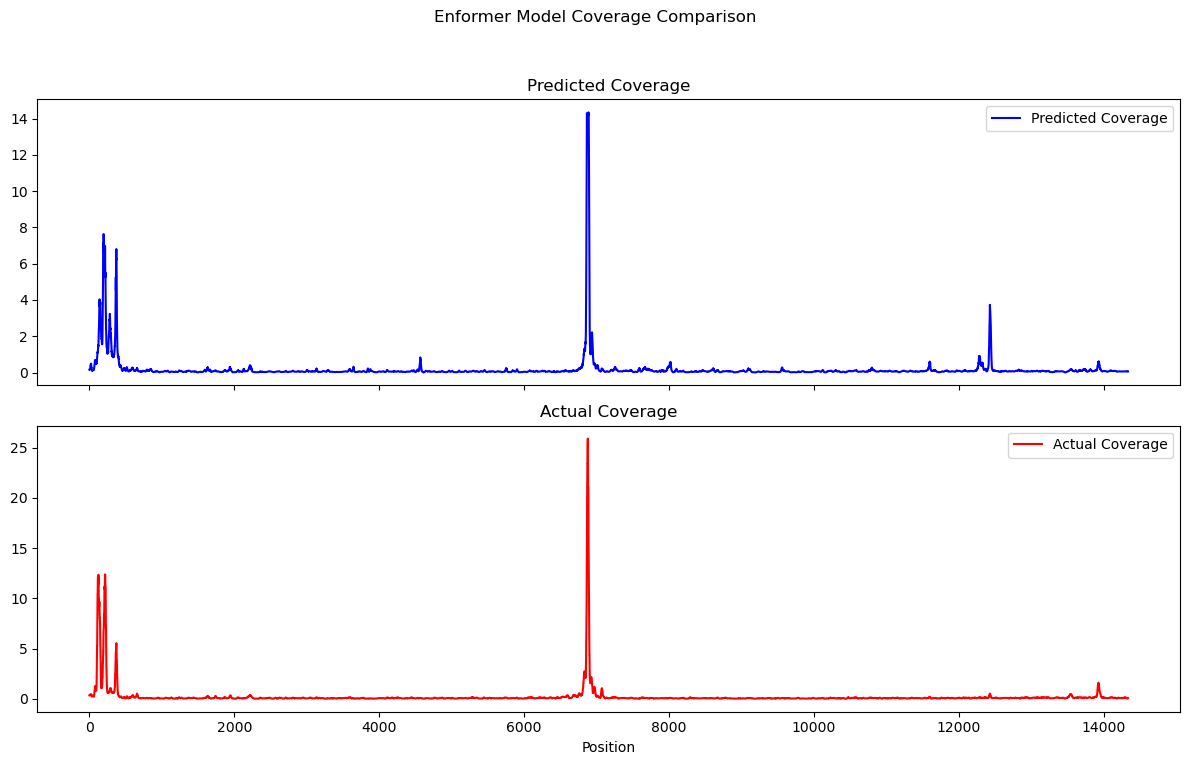

(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'Predicted Coverage'}>,
  <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>))

In [15]:
#let's now do it with the other models!!

#outputs/2025-01-25/12-09-36-269879
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/12-09-36-269879/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path)
evals.plot_track(3)

In [16]:
#let's just stack it all and make one larger plot
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
import evals.evals_utils_enformer as e
subdirs = [
    "2025-01-25/00-16-16-651049",
    "2025-01-25/12-09-36-269879",
    "2025-01-25/14-01-50-384463",
    "2025-01-25/14-02-50-070142"
] #corresponds to 1,8,32,128 base pairs

# Base path with placeholders
base_path = "/data1/lesliec/sarthak/caduceus/outputs/{}/checkpoints/last.ckpt"

# Create list of formatted paths
ckpt_paths = [base_path.format(subdir) for subdir in subdirs]
evals_list = []
for ckpt_path in ckpt_paths:
    print(ckpt_path)
# evals = e.Evals(ckpt_path)

/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/00-16-16-651049/checkpoints/last.ckpt
/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/12-09-36-269879/checkpoints/last.ckpt
/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/14-01-50-384463/checkpoints/last.ckpt
/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/14-02-50-070142/checkpoints/last.ckpt


In [17]:
evals_list = [e.Evals(ckpt_path) for ckpt_path in ckpt_paths]
evals_list

674
674
674
674


In [18]:
#first let's make sure what we are doing with the mean lines up
seq,label = evals_list[0].dataset[3]
seq_128,label_128 = evals_list[3].dataset[3]
print(label.shape, label_128.shape)

torch.Size([114688, 674]) torch.Size([896, 674])


In [19]:
#now let's make sure our approaches are similar
targets = label
targets = targets.view(targets.size(0) // 128, 128, targets.size(1))
# print(targets.shape)
targets = targets.mean(dim=1).cpu().numpy()
print(targets.shape)


(896, 674)


In [20]:
(targets == label_128.cpu().numpy()).all() #ok that's good, so this is correct and we're fine, this is logical tho since we did exactly the same thing!!

True

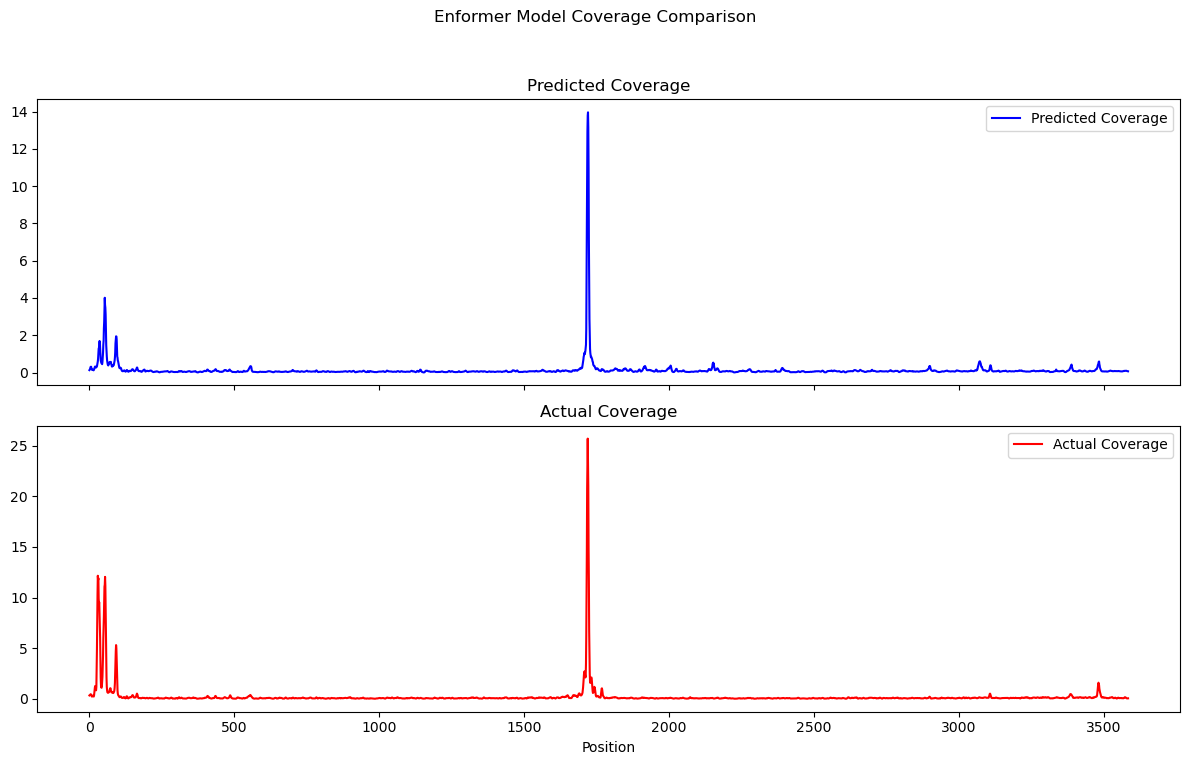

(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'Predicted Coverage'}>,
  <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>))

In [21]:
#now let's plot the tracks
#first the 32 base pair coverage
evals_list[2].plot_track(3)

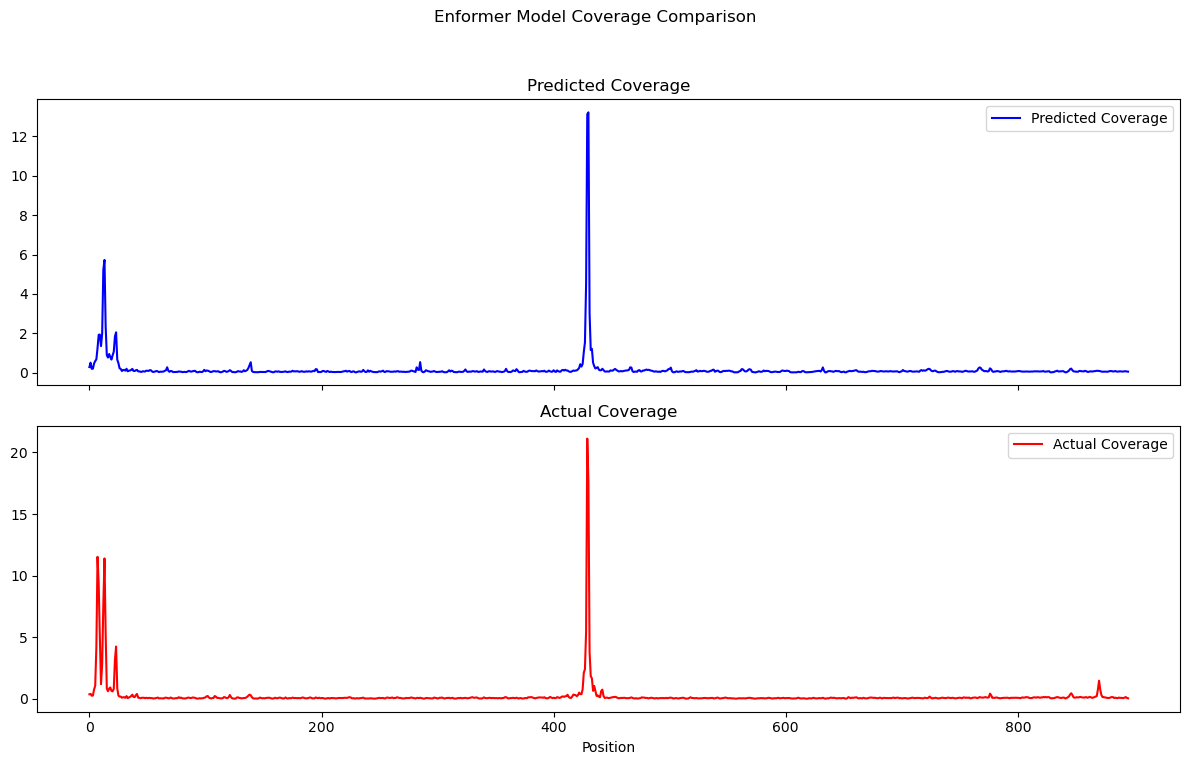

(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'Predicted Coverage'}>,
  <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>))

In [22]:
#and 128 base pair coverage
evals_list[3].plot_track(3)

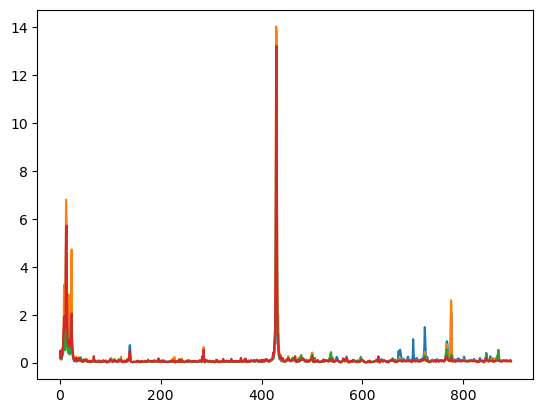

In [23]:
#now make one plot where we take all the outputs, pool them, then plot on the same subplot
pool_size_list = [1, 8, 32, 128]
for i in range(len(evals_list)):
    out = evals_list[i](3)
    out = out.squeeze(0)
    pool_size = 128//pool_size_list[i]
    out_128 = out.view(out.size(0) // pool_size, pool_size, out.size(1))
    out_128 = out_128.mean(dim=1).cpu().detach().numpy()
    plt.plot(out_128[:, 121], label=f'{2**i} bp Model')

Text(0.5, 1.0, 'Actual Coverage')

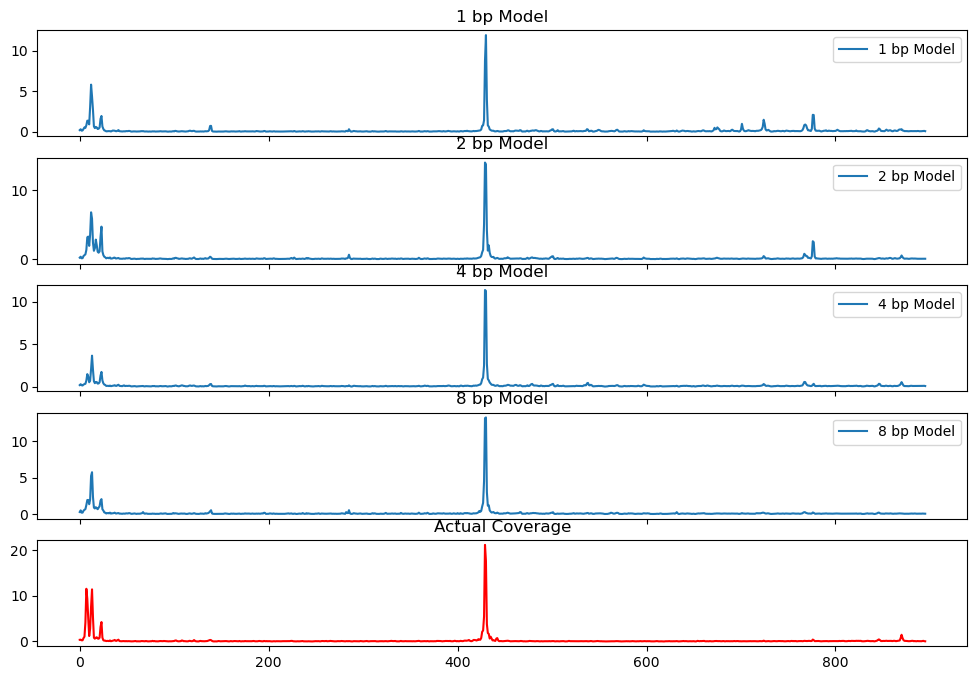

In [25]:
#now do the subplot approachg
fig, axs = plt.subplots(5, 1, figsize=(12, 8), sharex=True) #the first 4 plots are predicted, last is true
for i in range(len(evals_list)):
    out = evals_list[i](3)
    out = out.squeeze(0)
    pool_size = 128//pool_size_list[i]
    out_128 = out.view(out.size(0) // pool_size, pool_size, out.size(1))
    out_128 = out_128.mean(dim=1).cpu().detach().numpy()
    axs[i].plot(out_128[:, 121], label=f'{2**i} bp Model')
    axs[i].set_title(f'{2**i} bp Model')
    axs[i].legend()
axs[-1].plot(targets[:, 121], label='Actual Coverage', color='r')
axs[-1].set_title('Actual Coverage')

Text(0.5, 1.0, 'Actual Coverage')

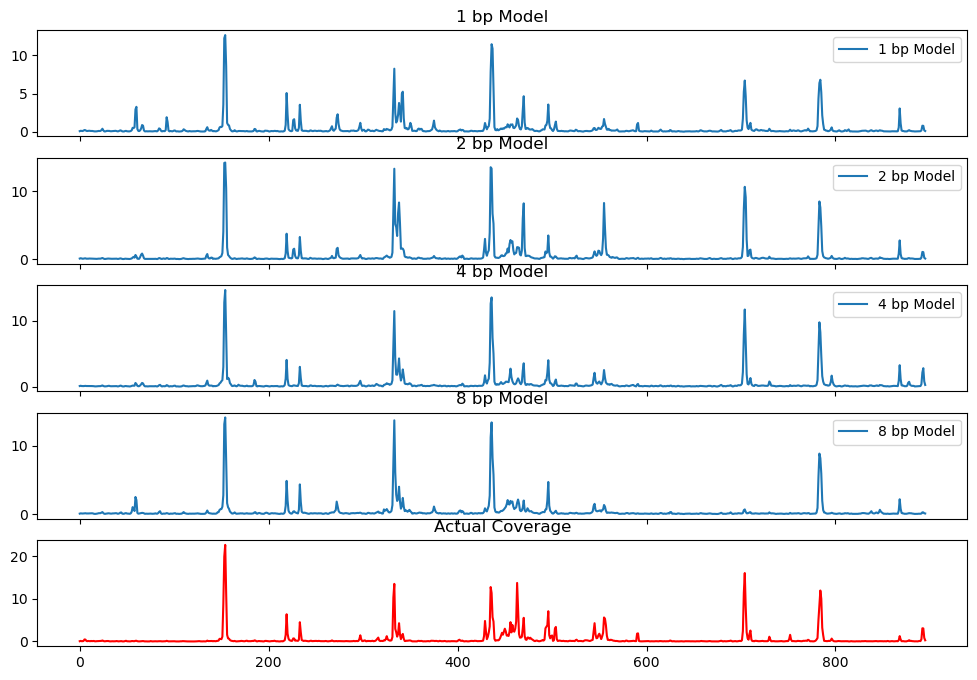

In [30]:
#now do the subplot approachg
fig, axs = plt.subplots(5, 1, figsize=(12, 8), sharex=True) #the first 4 plots are predicted, last is true
for i in range(len(evals_list)):
    out = evals_list[i](4)
    out = out.squeeze(0)
    pool_size = 128//pool_size_list[i]
    out_128 = out.view(out.size(0) // pool_size, pool_size, out.size(1))
    out_128 = out_128.mean(dim=1).cpu().detach().numpy()
    axs[i].plot(out_128[:, 121], label=f'{2**i} bp Model')
    axs[i].set_title(f'{2**i} bp Model')
    axs[i].legend()
targets = evals_list[-1].dataset[4][1]
axs[-1].plot(targets[:, 121], label='Actual Coverage', color='r')
axs[-1].set_title('Actual Coverage')

Text(0.5, 1.0, 'Actual Coverage')

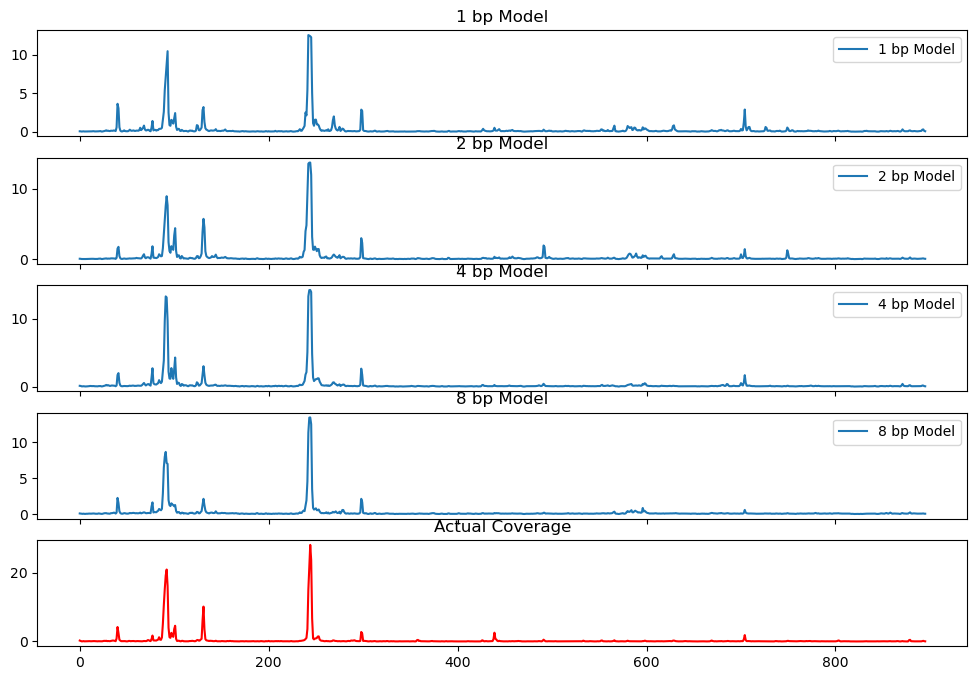

In [31]:
#now do the subplot approachg
idx = 5
fig, axs = plt.subplots(5, 1, figsize=(12, 8), sharex=True) #the first 4 plots are predicted, last is true
for i in range(len(evals_list)):
    out = evals_list[i](idx)
    out = out.squeeze(0)
    pool_size = 128//pool_size_list[i]
    out_128 = out.view(out.size(0) // pool_size, pool_size, out.size(1))
    out_128 = out_128.mean(dim=1).cpu().detach().numpy()
    axs[i].plot(out_128[:, 121], label=f'{2**i} bp Model')
    axs[i].set_title(f'{2**i} bp Model')
    axs[i].legend()
targets = evals_list[-1].dataset[idx][1]
axs[-1].plot(targets[:, 121], label='Actual Coverage', color='r')
axs[-1].set_title('Actual Coverage')

In [32]:
#now let's find another example
for i in range(100):
    seq,label = evals_list[0].dataset[i]
    if label[:,121].max() > 10:
        print(i)
        # break

3
4
5
17
20
22
25
35
46
47
52
57
73
79
83
84
85
87
90
92
94
95
96
98


In [33]:
#let's find examples for track 12
for i in range(100):
    seq,label = evals_list[0].dataset[i]
    if label[:,12].max() > 10:
        print(i)

4
87
95
98


Text(0.5, 1.0, 'Actual Coverage')

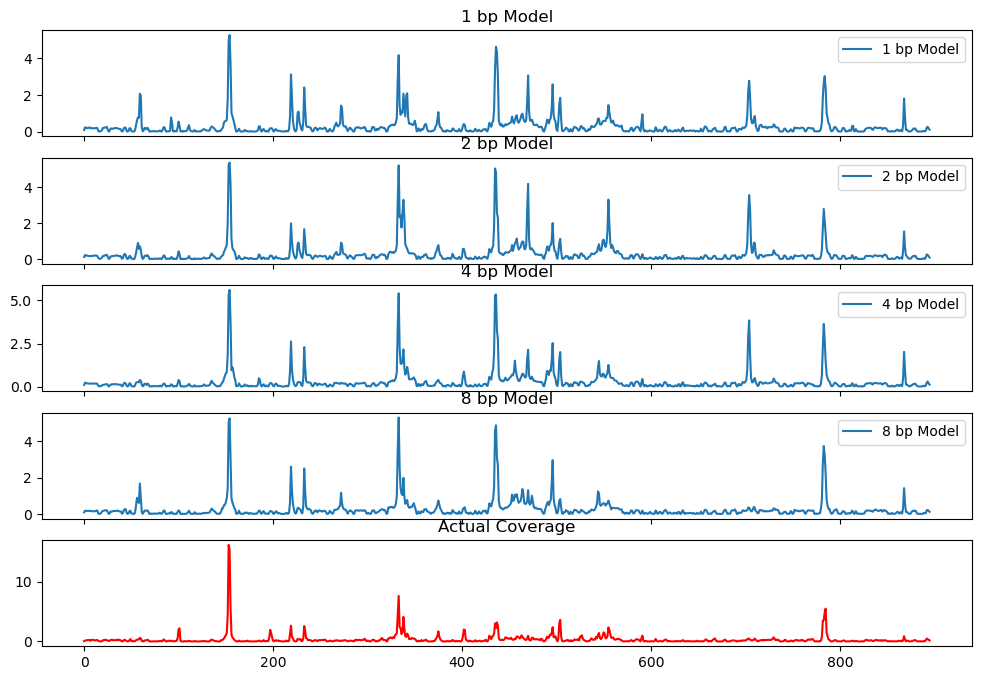

In [35]:
#now we can print some plots for GM12878
idx = 4
track = 12
fig, axs = plt.subplots(5, 1, figsize=(12, 8), sharex=True) #the first 4 plots are predicted, last is true
for i in range(len(evals_list)):
    out = evals_list[i](idx)
    out = out.squeeze(0)
    pool_size = 128//pool_size_list[i]
    out_128 = out.view(out.size(0) // pool_size, pool_size, out.size(1))
    out_128 = out_128.mean(dim=1).cpu().detach().numpy()
    axs[i].plot(out_128[:, track], label=f'{2**i} bp Model')
    axs[i].set_title(f'{2**i} bp Model')
    axs[i].legend()
targets = evals_list[-1].dataset[idx][1]
axs[-1].plot(targets[:, track], label='Actual Coverage', color='r')
axs[-1].set_title('Actual Coverage')

In [34]:
print('3')

3


# now properly evaluating all these models!

In [2]:
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
import evals.evals_utils_enformer as e
#this is for bp enformer
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/00-16-16-651049/checkpoints/06-val_loss=0.22732.ckpt'
evals = e.Evals(ckpt_path)
out = evals.dataset[0]
print(out[0].shape, out[1].shape)

base_path: /data1/lesliec/sarthak/
674
torch.Size([4, 196608]) torch.Size([114688, 674])


In [3]:
#let's get an idea of how long it would take to evaluate
outputs = evals.evaluate(batch_size=2)

100%|██████████| 969/969 [42:23<00:00,  2.62s/it]


# and let's make sure this works for the other models

In [1]:
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
import evals.evals_utils_enformer as e
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-02-05/12-33-11-311476/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path)
out = evals.dataset[0]
print(out[0].shape, out[1].shape)

base_path: /data1/lesliec/sarthak/
674
torch.Size([4, 524288]) torch.Size([896, 674])


In [2]:
out = evals(0)
out.shape

torch.Size([1, 896, 674])

In [1]:
#just updated the eval utils class, let's see if this works
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
import evals.evals_utils_enformer as e
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-02-05/12-33-11-311476/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path)
out = evals.dataset[0]
print(out[0].shape, out[1].shape)
out = evals(0)
out.shape

base_path: /data1/lesliec/sarthak/
674
torch.Size([4, 524288]) torch.Size([896, 674])


torch.Size([1, 896, 674])

In [4]:
#now here's the real test, see if it works for gpn msa models!
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-02-05/12-33-11-311701/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path, dataset_class='GPNMSA')
out = evals.dataset[0]
print(out[0].shape, out[1].shape)
out = evals(0)
out.shape

674
torch.Size([512, 196608]) torch.Size([896, 674])


torch.Size([1, 896, 674])

In [7]:
evals.backbone #no embedding, the embedding is just a transpose! Perfect, for the one that is just ohe!

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): Transpose()
      )
      (layers): ModuleList(
        (0-15): 16 x Block(
          (norm): RMSNorm()
          (mixer): BiMambaWrapper(
            (mamba_fwd): Mamba(
              (in_proj): Linear(in_features=512, out_features=2048, bias=False)
              (conv1d): Conv1d(1024, 1024, kernel_size=(4,), stride=(1,), padding=(3,), groups=1024)
              (act): SiLU()
              (x_proj): Linear(in_features=1024, out_features=64, bias=False)
              (dt_proj): Linear(in_features=32, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=512, bias=False)
            )
            (mamba_rev): Mamba(
              (in_proj): Linear(in_features=512, out_features=2048, bias=False)
              (conv1d): Conv1d(1024, 1024, kernel_size=(4,), stride=(1,), padding=(3,), groups=1024)
  

In [12]:
#let's make a list of the ones
'''
12, enformer, -1, outputs/2025-01-25/00-16-16-651049, enformer, Enformer_cnn_1bp, 
13, enformer, -1, outputs/2025-01-25/12-09-36-269879, enformer, Enformer_cnn_8bp, 
14, enformer, -1, outputs/2025-01-25/14-01-50-384463, enformer, Enformer_cnn_32bp, 
15, enformer, -1, outputs/2025-01-25/14-02-50-070142, enformer, Enformer_cnn_128bp, 
21, gpnmsa, -1, outputs/2025-02-05/12-33-11-305656, gpnmsa, gpnmsa_basic_cnn_2, 
22, enformer, -1, outputs/2025-02-05/12-33-11-311476, enformer, Enformer_cnn_128bp_524k_2, 
23, enformer, -1, outputs/2025-02-05/12-33-11-311519, enformer, Enformer_cnn_128bp_393k_2, 
24, gpnmsa, -1, outputs/2025-02-05/12-33-11-311701, gpnmsa, gpnmsa_basic_ohe_2, 

'''

labels_list = [12,13,14,15,21,22,23,24]
#now load the labels csv file
import pandas as pd
labels_df = pd.read_csv('/data1/lesliec/sarthak/caduceus/outputs/labels.csv')
labels_df = labels_df[labels_df['ID'].isin(labels_list)]
labels_df

,ID,experiment type,pretrained ID,output dir,wandb group,wandb name,pretrained path
11,12,enformer,-1,outputs/2025-01-25/00-16-16-651049,enformer,Enformer_cnn_1bp,
12,13,enformer,-1,outputs/2025-01-25/12-09-36-269879,enformer,Enformer_cnn_8bp,
13,14,enformer,-1,outputs/2025-01-25/14-01-50-384463,enformer,Enformer_cnn_32bp,
14,15,enformer,-1,outputs/2025-01-25/14-02-50-070142,enformer,Enformer_cnn_128bp,
20,21,gpnmsa,-1,outputs/2025-02-05/12-33-11-305656,gpnmsa,gpnmsa_basic_cnn_2,
21,22,enformer,-1,outputs/2025-02-05/12-33-11-311476,enformer,Enformer_cnn_128bp_524k_2,
22,23,enformer,-1,outputs/2025-02-05/12-33-11-311519,enformer,Enformer_cnn_128bp_393k_2,
23,24,gpnmsa,-1,outputs/2025-02-05/12-33-11-311701,gpnmsa,gpnmsa_basic_ohe_2,


In [15]:
#now go in reverse order and basically just grab the output dir and see if wandb group is gpn msa
for i in range(len(labels_df)):
    output_dir = labels_df.iloc[i][' output dir']
    wandb_group = labels_df.iloc[i][' wandb group']
    wandb_name = labels_df.iloc[i][' wandb name']
    print(output_dir, wandb_group, wandb_name)

 outputs/2025-01-25/00-16-16-651049  enformer  Enformer_cnn_1bp
 outputs/2025-01-25/12-09-36-269879  enformer  Enformer_cnn_8bp
 outputs/2025-01-25/14-01-50-384463  enformer  Enformer_cnn_32bp
 outputs/2025-01-25/14-02-50-070142  enformer  Enformer_cnn_128bp
 outputs/2025-02-05/12-33-11-305656  gpnmsa  gpnmsa_basic_cnn_2
 outputs/2025-02-05/12-33-11-311476  enformer  Enformer_cnn_128bp_524k_2
 outputs/2025-02-05/12-33-11-311519  enformer  Enformer_cnn_128bp_393k_2
 outputs/2025-02-05/12-33-11-311701  gpnmsa  gpnmsa_basic_ohe_2


In [ ]:
#and we can just do the rest in a script we'll make, should be easy enough!

# zarr file

In [1]:
#it's not actually that simple, as some of th ethings are large, like several hundred GB, let's see how big it would be
114688*674*2000/1e9 #that's like 154 GB if 8 bit, but 16 bit so like 300 GB. Yeah that's just for model outputs, let's go ahead and save it out with zarr again

import zarr
root = zarr.open(zarr_file_path, mode='w', zarr_format=2)

compression = zarr.codecs.BloscCodec(cname='zlib', clevel=9, shuffle=zarr.codecs.BloscShuffle.bitshuffle)

154.599424

# now doing the evaluation

In [3]:
#we have the zarr files, let's load them in!

import zarr
import os
out_path = '/data1/lesliec/sarthak/data/borzoi/model_outputs/'
#print files in this path
files = os.listdir(out_path)
files

['Enformer_cnn_128bp.zarr',
 'Enformer_cnn_32bp.zarr',
 'Enformer_cnn_1bp.zarr',
 'gpnmsa_basic_ohe_2.zarr',
 'Enformer_cnn_128bp_524k_2.zarr',
 'Enformer_cnn_8bp.zarr',
 'gpnmsa_basic_cnn_2.zarr',
 'Enformer_cnn_128bp_393k_2.zarr']

In [6]:
for file in files:
    if file.endswith('.zarr'):
        print(file)
        zarr_file_path = os.path.join(out_path, file)
        #now open the zarr file
        root = zarr.open(zarr_file_path, mode='r')
        #now let's see the shape of the data
        # print(root.shape)
        #now let's see the keys
        # print(root.keys())
        #now let's see the data
        data = root['evals']
        print(data.shape)

Enformer_cnn_128bp.zarr
(1937, 896, 674)
Enformer_cnn_32bp.zarr
(1937, 3584, 674)
Enformer_cnn_1bp.zarr
(1937, 114688, 674)
gpnmsa_basic_ohe_2.zarr
(1937, 896, 674)
Enformer_cnn_128bp_524k_2.zarr
(1937, 896, 674)
Enformer_cnn_8bp.zarr
(1937, 14336, 674)
gpnmsa_basic_cnn_2.zarr
(1937, 896, 674)
Enformer_cnn_128bp_393k_2.zarr
(1937, 896, 674)


In [7]:
#let's load this lat one into memory, since it's 128 bp, it should be realtively quick
print(file)

Enformer_cnn_128bp_393k_2.zarr


In [10]:
root = zarr.open(zarr_file_path, mode='r')
data = root['evals'][:]
print(data.nbytes/1e9)

2.339524096


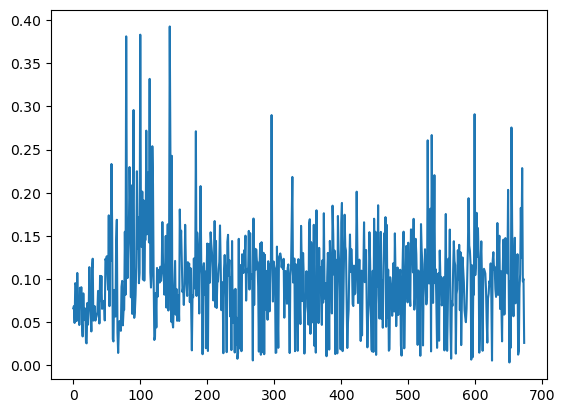

In [12]:
#loads in 2.3 seconds, not bad at all! let's see if any of the rows are 0
import matplotlib.pyplot as plt
plt.plot(data[0,0,:])

In [13]:
#and now the sum
data.sum(axis=0).shape

(896, 674)

In [14]:
data.sum(0).min() #ahh perfect!! 

35.7

In [15]:
import os
os.getcwd()

'/data1/lesliec/sarthak/caduceus'

In [18]:
#and what we need to do now is test zarr what if we try to create an array twice, let's make a test zarr file
import zarr
root = zarr.open('test.zarr', mode='w', zarr_format=2)
root.create_array('evals', shape=(100, 100, 100), chunks=(10, 10, 10), dtype='float32')
data = root['evals']
data.shape

(100, 100, 100)

In [19]:
#what if we try to create it again
root.create_array('evals', shape=(100, 100, 100), chunks=(10, 10, 10), dtype='float32')
#ok perfect, won't override it!!

ContainsArrayError: An array exists in store LocalStore('file://test.zarr') at path 'evals'.

In [20]:
#what if we do this
root.create_array('evals', shape=(100, 100, 100), chunks=(10, 10, 10), dtype='float32', mode='w')
#ok can't overwrite it like that, that's fine!!

TypeError: Group.create_array() got an unexpected keyword argument 'mode'

In [21]:
#one option is test if it works, and can allow a ContainsArrayError!
try:
    root.create_array('evals', shape=(100, 100, 100), chunks=(10, 10, 10), dtype='float32')
except zarr.errors.ContainsArrayError:
    print("Array already exists")


Array already exists


In [25]:
#now let's take this through a test run
root = zarr.open('/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_128bp_393k_2.zarr', mode='r+', zarr_format=2)
root.tree()

/
└── evals (1937, 896, 674) float16

In [29]:
#let's make a tes tmatrix
import numpy as np

test_out = np.random.rand(6,674)
print(test_out.shape)

from scipy.stats import spearmanr
#now do spearmanr with itself
for i in range(test_out.shape[0]):
    corr,_ = spearmanr(test_out[i,:], test_out[i,:])
    print(corr)

#this is wrong as we want to keep that dimension, but it's ok, just make sure to loop over the track dimension, not th elength dimension

(6, 674)
1.0
1.0
1.0
1.0
1.0
1.0


In [31]:
#see what the size of correlations should be, should be 1 per track and per sample, so should be samples x tracks
#now the issue is actually saving it out, so we'll use zarr to do it

import pandas as pd
import sys
import evals.evals_utils_enformer as e
import torch
import os
import zarr
from tqdm import tqdm
from scipy.stats import spearmanr

# compression = Blosc(cname='zlib', clevel=9, shuffle=Blosc.BITSHUFFLE) #we will not be doing compression

labels_list = [12,13,14,15,21,22,23,24]

labels_df = pd.read_csv('/data1/lesliec/sarthak/caduceus/outputs/labels.csv')
labels_df = labels_df[labels_df['ID'].isin(labels_list)]
out_path = '/data1/lesliec/sarthak/data/borzoi/model_outputs/'
for i in range(len(labels_df)):
    output_dir = labels_df.iloc[i][' output dir'].strip()
    wandb_group = labels_df.iloc[i][' wandb group'].strip()
    wandb_name = labels_df.iloc[i][' wandb name'].strip()
    print(output_dir, wandb_group, wandb_name)
    
    #first load in everything
    
    ckpt_path = f'/data1/lesliec/sarthak/caduceus/{output_dir}/checkpoints/last.ckpt'
    if wandb_group == 'gpnmsa':
        dataset_class = 'GPNMSA'
    else:
        dataset_class = 'Enformer'
    evals = e.Evals(ckpt_path, dataset_class=dataset_class)
    root = zarr.open(f'{out_path}/{wandb_name}.zarr', mode='r+')
    print('evals array shape:',root['evals'].shape)

    # try:
    #     root.create_array('corrs', shape=(len(evals.dataset), 674), chunks=(1, 674), dtype='float32')
    # except zarr.errors.ContainsArrayError:
    #     print("corr Array already exists")
    
    for j in tqdm(range(len(evals.dataset))):
        # root['corrs'][j] = out.detach().cpu().squeeze().numpy()
        #now we loop through the outputs
        data,label = evals.dataset[j]
        out = root['evals'][j]
        print(label.shape, out.shape)
        break
    

base_path: /data1/lesliec/sarthak/
outputs/2025-01-25/00-16-16-651049 enformer Enformer_cnn_1bp
674
evals array shape: (1937, 114688, 674)


  0%|          | 0/1937 [00:00<?, ?it/s]

torch.Size([114688, 674]) (114688, 674)
outputs/2025-01-25/12-09-36-269879 enformer Enformer_cnn_8bp


674
evals array shape: (1937, 14336, 674)


  0%|          | 0/1937 [00:01<?, ?it/s]

torch.Size([14336, 674]) (14336, 674)
outputs/2025-01-25/14-01-50-384463 enformer Enformer_cnn_32bp


674
evals array shape: (1937, 3584, 674)


  0%|          | 0/1937 [00:00<?, ?it/s]

torch.Size([3584, 674]) (3584, 674)
outputs/2025-01-25/14-02-50-070142 enformer Enformer_cnn_128bp


674
evals array shape: (1937, 896, 674)


  0%|          | 0/1937 [00:00<?, ?it/s]

torch.Size([896, 674]) (896, 674)
outputs/2025-02-05/12-33-11-305656 gpnmsa gpnmsa_basic_cnn_2


674
evals array shape: (1937, 896, 674)


  0%|          | 0/1937 [00:01<?, ?it/s]

torch.Size([896, 674]) (896, 674)
outputs/2025-02-05/12-33-11-311476 enformer Enformer_cnn_128bp_524k_2


674
evals array shape: (1937, 896, 674)


  0%|          | 0/1937 [00:00<?, ?it/s]

torch.Size([896, 674]) (896, 674)
outputs/2025-02-05/12-33-11-311519 enformer Enformer_cnn_128bp_393k_2


674
evals array shape: (1937, 896, 674)


  0%|          | 0/1937 [00:00<?, ?it/s]

torch.Size([896, 674]) (896, 674)
outputs/2025-02-05/12-33-11-311701 gpnmsa gpnmsa_basic_ohe_2


674
evals array shape: (1937, 896, 674)


  0%|          | 0/1937 [00:01<?, ?it/s]

torch.Size([896, 674]) (896, 674)


In [ ]:
#and let's save it out

#last thing is we need to add a loop over the tracks, which is the last thing of output

# comparing models

In [32]:
files

['Enformer_cnn_128bp.zarr',
 'Enformer_cnn_32bp.zarr',
 'Enformer_cnn_1bp.zarr',
 'gpnmsa_basic_ohe_2.zarr',
 'Enformer_cnn_128bp_524k_2.zarr',
 'Enformer_cnn_8bp.zarr',
 'gpnmsa_basic_cnn_2.zarr',
 'Enformer_cnn_128bp_393k_2.zarr']

In [34]:
#now that the evaluation is done, let's compare the models, first we need to get correlations to bin the models at lower resolutions, can save it in the thing again
path_1bp = '/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_1bp.zarr'
root_1bp = zarr.open(path_1bp, mode='r+')
path_8bp = '/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_8bp.zarr'
root_8bp = zarr.open(path_8bp, mode='r+')
path_32bp = '/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_32bp.zarr'
root_32bp = zarr.open(path_32bp, mode='r+')
path_128bp = '/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_128bp.zarr'
root_128bp = zarr.open(path_128bp, mode='r')

print(root_1bp.tree())
print(root_8bp.tree())
print(root_32bp.tree())
print(root_128bp.tree())

/
├── corrs (1937, 674) float32
└── evals (1937, 114688, 674) float16

/
└── evals (1937, 14336, 674) float16

/
└── evals (1937, 3584, 674) float16

/
└── evals (1937, 896, 674) float16

In [35]:
#so far only 1 is running, that's why it's the only one with corrs, but we will make it so that it has all corrs!!
#so start by getting the 8 bp evals, running on 1bp, then get the 32 bp evals, run on 1bp and 8bp, then get the 128 bp evals, run on 1bp, 8bp and 32bp

#first make sure we can get and convert the actual output correctly
s1 = root_1bp['evals'][0]
s1.shape

(114688, 674)

In [48]:
s1view = s1.reshape(s1.shape[0] // 8, 8, s1.shape[1])
s1mean = s1view.mean(1)
s1mean.shape

(14336, 674)

In [54]:
#now let's just test some values
(s1[:8,:].mean(0) == s1mean[0,:]).all()

True

In [55]:
(s1[8:16,:].mean(0) == s1mean[1,:]).all()

True

In [56]:
#and the last 8
(s1[-8:,:].mean(0) == s1mean[-1,:]).all()

True

In [57]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/12-09-36-269879/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path)
out = evals.dataset[0]
print(out[0].shape, out[1].shape)

674
torch.Size([4, 196608]) torch.Size([14336, 674])


In [59]:
#ok so this reshaping approach clearly works, now load it in, reshape and we're good!!

try:
    root_1bp.create_array('corrs_8', shape=(len(evals.dataset), 674), chunks=(1, 674), dtype='float32')
except zarr.errors.ContainsArrayError:
    print("corr Array already exists")
    assert root_1bp['corrs_8'].shape == (len(evals.dataset), 674), f"Shape mismatch: {root['corrs'].shape} vs {(len(evals.dataset), 674)}"

In [60]:
root_1bp.tree()

/
├── corrs (1937, 674) float32
├── corrs_8 (1937, 674) float32
└── evals (1937, 114688, 674) float16

In [64]:
pool = 8
for j in tqdm(range(len(evals.dataset))):
    data,label = evals.dataset[j]
    out = root_1bp['evals'][j]
    out = out.reshape(out.shape[0] // pool, pool, out.shape[1]).mean(1)
    label = label.numpy() #just because it's now a numpy array we can calculate the correlation of
    corrs = np.zeros((label.shape[1]))
    for k in range(label.shape[1]):
        corr = spearmanr(label[:,k], out[:,k])
        corrs[k] = corr.correlation if not np.isnan(corr.correlation) else 0.0 #basically sets it to 0 if nan!  
    root_1bp['corrs_8'][j] = corrs

 65%|██████▍   | 1254/1937 [57:43<30:44,  2.70s/it] /data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|██████████| 1937/1937 [1:29:29<00:00,  2.77s/it]


In [63]:
label.shape, out.shape #this is what happens before the mean, so I fixed it in the code!!

((14336, 674), (14336, 8, 674))

In [80]:
#now let's do this for the 32bp pooling model

#first create the zarr files

try:
    root_1bp.create_array('corrs_32', shape=(len(evals.dataset), 674), chunks=(1, 674), dtype='float32')
    root_8bp.create_array('corrs_32', shape=(len(evals.dataset), 674), chunks=(1, 674), dtype='float32')
except zarr.errors.ContainsArrayError:
    print("corr Array already exists")
    assert root_1bp['corrs_32'].shape == (len(evals.dataset), 674), f"Shape mismatch: {root['corrs'].shape} vs {(len(evals.dataset), 674)}"
    assert root_8bp['corrs_32'].shape == (len(evals.dataset), 674), f"Shape mismatch: {root['corrs'].shape} vs {(len(evals.dataset), 674)}"
    
#now define an eval for the 32bp model
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/14-01-50-384463/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path)

pool = 32
for j in tqdm(range(len(evals.dataset))):
    data,label = evals.dataset[j]
    out_1bp = root_1bp['evals'][j]
    out_1bp = out_1bp.reshape(out_1bp.shape[0] // pool, pool, out_1bp.shape[1]).mean(1)
    out_8bp = root_8bp['evals'][j]
    out_8bp = out_8bp.reshape(out_8bp.shape[0] // (pool//8), pool//8, out_8bp.shape[1]).mean(1) #divide by 4 cuz 8 is already pooled a bit!
    label = label.numpy() #just because it's now a numpy array we can calculate the correlation of
    corrs_1bp = np.zeros((label.shape[1]))
    corrs_8bp = np.zeros((label.shape[1]))
    for k in range(label.shape[1]):
        corr = spearmanr(label[:,k], out_1bp[:,k])
        corrs_1bp[k] = corr.correlation if not np.isnan(corr.correlation) else 0.0 #basically sets it to 0 if nan!  
        corr = spearmanr(label[:,k], out_8bp[:,k])
        corrs_8bp[k] = corr.correlation if not np.isnan(corr.correlation) else 0.0
    root_1bp['corrs_32'][j] = corrs_1bp
    root_8bp['corrs_32'][j] = corrs_8bp
    


corr Array already exists


674


 65%|██████▍   | 1254/1937 [51:26<27:19,  2.40s/it] /data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|██████████| 1937/1937 [1:19:06<00:00,  2.45s/it]


In [67]:
label.shape, out_1bp.shape #this should be correct... I see why 8 bp is wrong, but why is this wrong??

((3584, 674), (448, 674))

In [68]:
root_1bp['evals'][j].shape

(114688, 674)

In [69]:
114688/32

3584.0

In [72]:
out_1bp = root_1bp['evals'][j].shape
out_1bp = out.reshape(out.shape[0] // pool, pool, out.shape[1]) #ahh have to use out 1bp
out_1bp.shape

(448, 32, 674)

In [78]:
label.shape, out_8bp.shape #this is not ideal, wtf, we should be pooling by 4, I see...


((3584, 674), (1792, 674))

In [79]:
32/4 #ahh already pooled 8 so pool 8 less!

8.0

In [81]:
#and now we do it pooled at 128

#now let's do this for the 32bp pooling model

#first create the zarr files

try:
    root_1bp.create_array('corrs_128', shape=(len(evals.dataset), 674), chunks=(1, 674), dtype='float32')
    root_8bp.create_array('corrs_128', shape=(len(evals.dataset), 674), chunks=(1, 674), dtype='float32')
    root_32bp.create_array('corrs_128', shape=(len(evals.dataset), 674), chunks=(1, 674), dtype='float32')
except zarr.errors.ContainsArrayError:
    print("corr Array already exists")
    assert root_1bp['corrs_128'].shape == (len(evals.dataset), 674), f"Shape mismatch: {root['corrs'].shape} vs {(len(evals.dataset), 674)}"
    assert root_8bp['corrs_128'].shape == (len(evals.dataset), 674), f"Shape mismatch: {root['corrs'].shape} vs {(len(evals.dataset), 674)}"
    assert root_32bp['corrs_128'].shape == (len(evals.dataset), 674), f"Shape mismatch: {root['corrs'].shape} vs {(len(evals.dataset), 674)}"
    
#now define an eval for the 32bp model
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-01-25/14-02-50-070142/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path)

pool = 128
for j in tqdm(range(len(evals.dataset))):
    data,label = evals.dataset[j]
    out_1bp = root_1bp['evals'][j]
    out_1bp = out_1bp.reshape(out_1bp.shape[0] // pool, pool, out_1bp.shape[1]).mean(1)
    out_8bp = root_8bp['evals'][j]
    out_8bp = out_8bp.reshape(out_8bp.shape[0] // (pool//8), pool//8, out_8bp.shape[1]).mean(1) #divide by 4 cuz 8 is already pooled a bit!
    out_32bp = root_32bp['evals'][j]
    out_32bp = out_32bp.reshape(out_32bp.shape[0] // (pool//32), pool//32, out_32bp.shape[1]).mean(1) #divide by 4 cuz 8 is already pooled a bit!
    label = label.numpy() #just because it's now a numpy array we can calculate the correlation of
    corrs_1bp = np.zeros((label.shape[1]))
    corrs_8bp = np.zeros((label.shape[1]))
    corrs_32bp = np.zeros((label.shape[1]))
    for k in range(label.shape[1]):
        corr = spearmanr(label[:,k], out_1bp[:,k])
        corrs_1bp[k] = corr.correlation if not np.isnan(corr.correlation) else 0.0 #basically sets it to 0 if nan!  
        corr = spearmanr(label[:,k], out_8bp[:,k])
        corrs_8bp[k] = corr.correlation if not np.isnan(corr.correlation) else 0.0
        corr = spearmanr(label[:,k], out_32bp[:,k])
        corrs_32bp[k] = corr.correlation if not np.isnan(corr.correlation) else 0.0
    root_1bp['corrs_128'][j] = corrs_1bp
    root_8bp['corrs_128'][j] = corrs_8bp
    root_32bp['corrs_128'][j] = corrs_32bp
    


674


 65%|██████▍   | 1254/1937 [40:41<22:09,  1.95s/it] /data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|██████████| 1937/1937 [1:02:46<00:00,  1.94s/it]


# and now let's check and evaluate

In [82]:
#so we have these files
'''
1.7G	Enformer_cnn_128bp_393k_2.zarr
0	ENformer_cnn_128bp_393k_2.zarr
1.7G	Enformer_cnn_128bp_524k_2.zarr
1.7G	Enformer_cnn_128bp.zarr
193G	Enformer_cnn_1bp.zarr
6.7G	Enformer_cnn_32bp.zarr
26G	Enformer_cnn_8bp.zarr
1.7G	gpnmsa_basic_cnn_2.zarr
1.7G	gpnmsa_basic_ohe_2.zarr
'''

#clearly there's an issue with tne ENformer one, let's check! I don't know how there would be 2 of them? Let's see if there's anything in there
#wai tit's empty, I think that one was on accident, it's fine!
#now let's open them all and do a tree
import os
main_path = '/data1/lesliec/sarthak/data/borzoi/model_outputs/'
files = os.listdir(main_path)
files

['Enformer_cnn_128bp.zarr',
 'Enformer_cnn_32bp.zarr',
 'Enformer_cnn_1bp.zarr',
 'gpnmsa_basic_ohe_2.zarr',
 'Enformer_cnn_128bp_524k_2.zarr',
 'Enformer_cnn_8bp.zarr',
 'gpnmsa_basic_cnn_2.zarr',
 'Enformer_cnn_128bp_393k_2.zarr']

In [87]:
#now we simpmly have to open the zarr files, let's do a key value thing, nah list is fine
zarr_stores = []
for file in files:
    file_path = main_path+file
    print(file_path)
    zarr_open = zarr.open(file_path, mode='r')
    print(zarr_open.tree())
    zarr_stores.append(zarr_open)

/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_128bp.zarr


/
├── corrs (1937, 674) float32
└── evals (1937, 896, 674) float16


/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_32bp.zarr


/
├── corrs (1937, 674) float32
├── corrs_128 (1937, 674) float32
└── evals (1937, 3584, 674) float16


/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_1bp.zarr


/
├── corrs (1937, 674) float32
├── corrs_128 (1937, 674) float32
├── corrs_32 (1937, 674) float32
├── corrs_8 (1937, 674) float32
└── evals (1937, 114688, 674) float16


/data1/lesliec/sarthak/data/borzoi/model_outputs/gpnmsa_basic_ohe_2.zarr


/
├── corrs (1937, 674) float32
└── evals (1937, 896, 674) float16


/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_128bp_524k_2.zarr


/
├── corrs (1937, 674) float32
└── evals (1937, 896, 674) float16


/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_8bp.zarr


/
├── corrs (1937, 674) float32
├── corrs_128 (1937, 674) float32
├── corrs_32 (1937, 674) float32
└── evals (1937, 14336, 674) float16


/data1/lesliec/sarthak/data/borzoi/model_outputs/gpnmsa_basic_cnn_2.zarr


/
├── corrs (1937, 674) float32
└── evals (1937, 896, 674) float16


/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_128bp_393k_2.zarr


/
├── corrs (1937, 674) float32
└── evals (1937, 896, 674) float16

In [92]:
#ok this is great! now we can simply do a violin plot!
for i in range(len(zarr_stores)):
    eval_data = zarr_stores[i]['corrs'][:]
    group_name = files[i]
    print(group_name,eval_data.shape)
#loads the whole thing quite quicly!

Enformer_cnn_128bp.zarr (1937, 674)
Enformer_cnn_32bp.zarr (1937, 674)
Enformer_cnn_1bp.zarr (1937, 674)
gpnmsa_basic_ohe_2.zarr (1937, 674)
Enformer_cnn_128bp_524k_2.zarr (1937, 674)
Enformer_cnn_8bp.zarr (1937, 674)
gpnmsa_basic_cnn_2.zarr (1937, 674)
Enformer_cnn_128bp_393k_2.zarr (1937, 674)


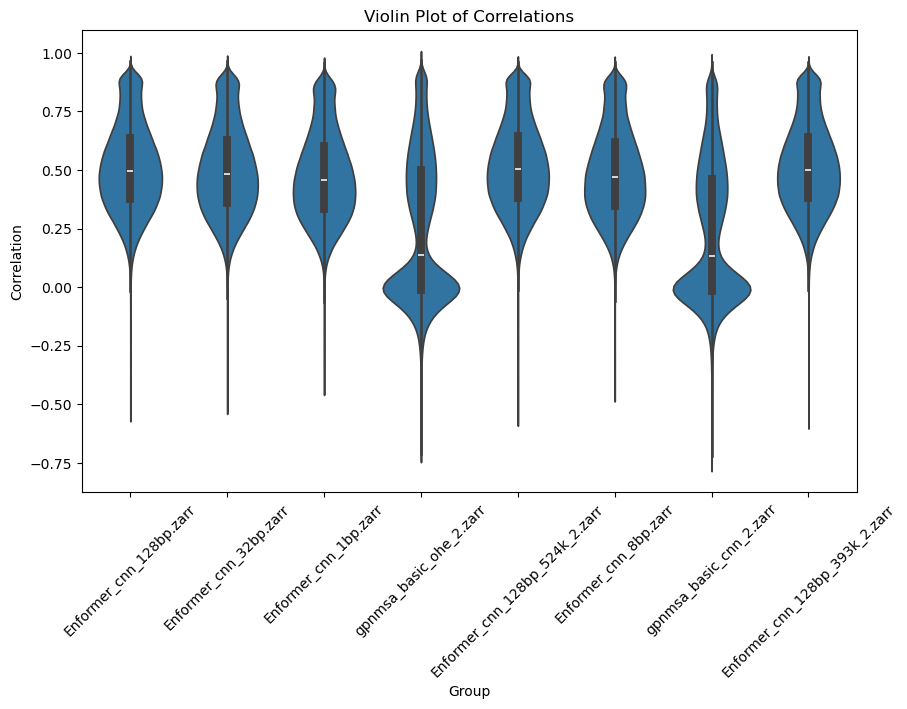

In [93]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = []  # Store all data points
groups = []  # Store corresponding group names

for i in range(len(zarr_stores)):
    eval_data = zarr_stores[i]['corrs'][:].flatten()  # Flatten to 1D
    group_name = files[i]  # Name of the group

    # Append all values and their group labels
    data.extend(eval_data)
    groups.extend([group_name] * len(eval_data))

# Create a Pandas DataFrame
df = pd.DataFrame({"Correlation": data, "Group": groups})

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Group", y="Correlation", data=df)

# Improve readability
plt.xticks(rotation=45)  # Rotate labels if necessary
plt.title("Violin Plot of Correlations")
plt.show()


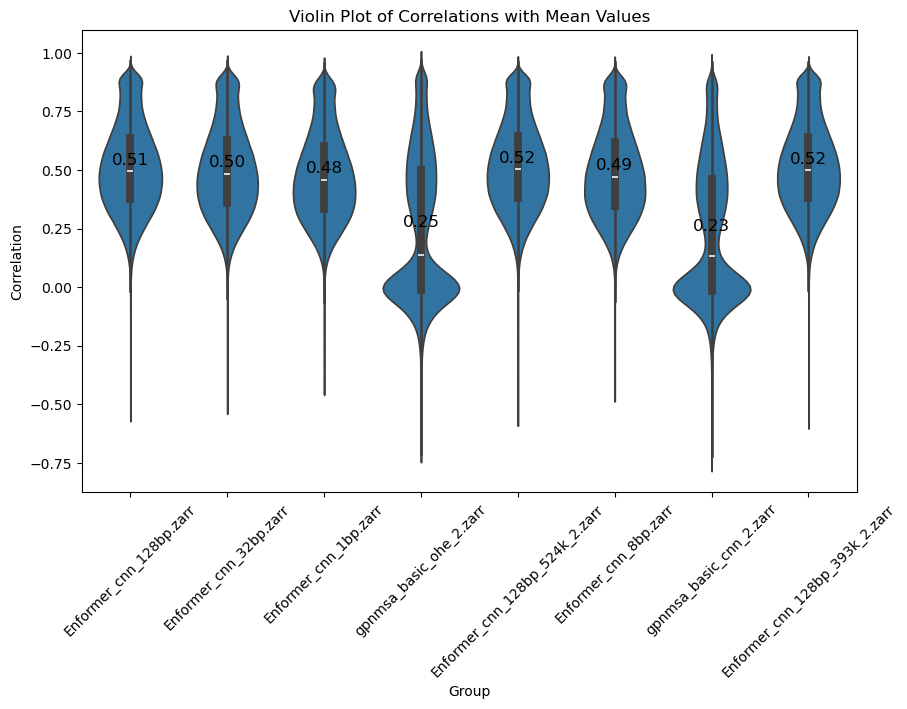

In [94]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = []  # Store all data points
groups = []  # Store corresponding group names
means = {}  # Store mean values for each group

for i in range(len(zarr_stores)):
    eval_data = zarr_stores[i]['corrs'][:].flatten()  # Flatten to 1D
    group_name = files[i]  # Name of the group

    # Store mean for annotation
    means[group_name] = eval_data.mean()

    # Append all values and their group labels
    data.extend(eval_data)
    groups.extend([group_name] * len(eval_data))

# Create a Pandas DataFrame
df = pd.DataFrame({"Correlation": data, "Group": groups})

# Plot the violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x="Group", y="Correlation", data=df)

# Annotate mean values above each group
for i, group in enumerate(df["Group"].unique()):
    mean_value = means[group]
    ax.text(i, mean_value, f"{mean_value:.2f}", ha="center", va="bottom", fontsize=12, color="black")

# Improve readability
plt.xticks(rotation=45)  # Rotate labels if necessary
plt.title("Violin Plot of Correlations with Mean Values")
plt.show()


In [95]:
#now we need to plot the correlations across coverage values and see if that changes anything

#start by seeing files

for file in files:
    if 'bp' in file:
        print(file)

Enformer_cnn_128bp.zarr
Enformer_cnn_32bp.zarr
Enformer_cnn_1bp.zarr
Enformer_cnn_128bp_524k_2.zarr
Enformer_cnn_8bp.zarr
Enformer_cnn_128bp_393k_2.zarr


In [96]:
#best to manually get it
#let's just print the values
files

['Enformer_cnn_128bp.zarr',
 'Enformer_cnn_32bp.zarr',
 'Enformer_cnn_1bp.zarr',
 'gpnmsa_basic_ohe_2.zarr',
 'Enformer_cnn_128bp_524k_2.zarr',
 'Enformer_cnn_8bp.zarr',
 'gpnmsa_basic_cnn_2.zarr',
 'Enformer_cnn_128bp_393k_2.zarr']

In [97]:
print('32 bp at 128 bp coverage:',zarr_stores[1]['corrs_128'][:].mean())

print('8 bp at 32 bp coverage:',zarr_stores[5]['corrs_32'][:].mean())
print('8 bp at 128 bp coverage:',zarr_stores[5]['corrs_128'][:].mean())

print('1 bp at 8 bp coverage:',zarr_stores[2]['corrs_8'][:].mean())
print('1 bp at 32 bp coverage:',zarr_stores[2]['corrs_32'][:].mean())
print('1 bp at 128 bp coverage:',zarr_stores[2]['corrs_128'][:].mean())


32 bp at 128 bp coverage: 0.5241711
8 bp at 32 bp coverage: 0.49770698
8 bp at 128 bp coverage: 0.5226751
1 bp at 8 bp coverage: 0.479708
1 bp at 32 bp coverage: 0.48787555
1 bp at 128 bp coverage: 0.51260424


# reviewing the gpn msa models

In [2]:
#this is strange, why is it so bad but has lower loss? let's load it in with our evalualtion utils and see if anything is wrong? I think it's fine tho?
#maybe some issue with loading from the config... maybe it's an issue with the dataset? let's find an exxample output form the dataset, that way we can manually verify it!
#let's first load in the easy way and just use that?

import pandas as pd
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
import evals.evals_utils_enformer as e
import torch
import os
import zarr
from numcodecs import Blosc
from tqdm import tqdm

output_dir = 'outputs/2025-02-05/12-33-11-311701'
ckpt_path = f'/data1/lesliec/sarthak/caduceus/{output_dir}/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path, dataset_class='GPNMSA')
out = evals.dataset[0]
print(out[0].shape, out[1].shape)
print(out[0])

674
torch.Size([512, 196608]) torch.Size([896, 674])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [4]:
out[0][0,:30] #definitely one hot encoded!

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.])

In [7]:
out = evals(0).detach().cpu().numpy()
print(out.shape)

(1, 896, 674)


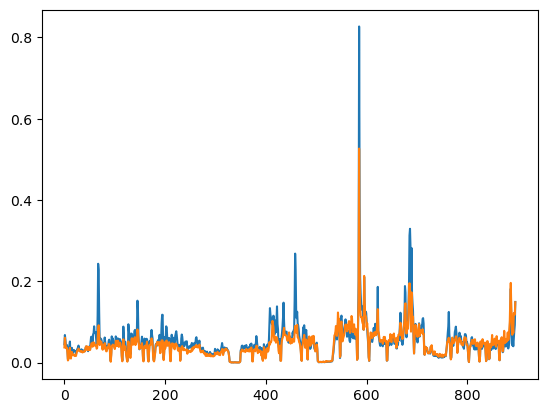

In [8]:
import matplotlib.pyplot as plt
plt.plot(out[0,:,0])
plt.plot(out[0,:,1])

In [9]:
#let's make sure this is what is in the zarr file
zarr_open = zarr.open('/data1/lesliec/sarthak/data/borzoi/model_outputs/gpnmsa_basic_ohe_2.zarr', mode='r')
zarr_open['evals'].shape

(1937, 896, 674)

In [11]:
out_zarr = zarr_open['evals'][0]
print((out_zarr[:,0] == out[0,:,0]).all()) #this is good, so the output is correct
#and th enext
print((out_zarr[:,1] == out[0,:,1]).all()) #this is good, so the output is correct

False
False


In [12]:
#wait why is this wrong?
print(out_zarr[:,0].shape, out_zarr[:,1].shape)
print(out[0,:,0].shape, out[0,:,1].shape)

(896,) (896,)
(896,) (896,)


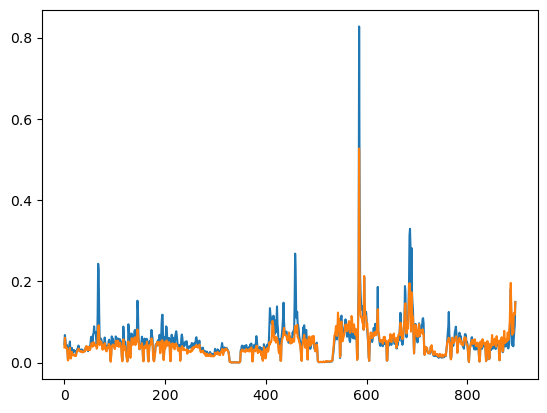

In [14]:
plt.plot(out_zarr[:,0])
plt.plot(out_zarr[:,1])

In [17]:
#it looks the same, I think maybe minor differences due to storage? let's check if it's close
import numpy as np
np.allclose(out_zarr[:,0], out[0,:,0]) #this is good, so the output is correct

False

In [18]:
out_zarr[:,0]

array([4.5197e-02, 6.7993e-02, 5.7068e-02, 4.2908e-02, 4.3427e-02,
       4.3488e-02, 3.1311e-02, 8.4534e-03, 1.1833e-02, 3.4637e-02,
       4.3793e-02, 5.1971e-02, 1.8585e-02, 1.5312e-02, 3.5339e-02,
       3.6499e-02, 2.3163e-02, 2.4261e-02, 3.0319e-02, 3.1311e-02,
       2.8564e-02, 2.8671e-02, 2.6443e-02, 2.1790e-02, 2.5970e-02,
       3.1647e-02, 3.4454e-02, 3.7323e-02, 4.2114e-02, 3.6743e-02,
       3.0792e-02, 2.9831e-02, 2.7817e-02, 2.8656e-02, 3.2898e-02,
       2.8839e-02, 2.9083e-02, 3.0350e-02, 2.7069e-02, 2.9221e-02,
       2.8702e-02, 2.8152e-02, 3.5492e-02, 3.9764e-02, 3.4119e-02,
       3.5919e-02, 3.8116e-02, 2.8275e-02, 3.6713e-02, 3.9337e-02,
       3.4302e-02, 3.3142e-02, 5.0354e-02, 6.3477e-02, 6.3782e-02,
       6.2561e-02, 4.9561e-02, 6.9885e-02, 7.2388e-02, 8.9355e-02,
       7.3730e-02, 7.4219e-02, 7.5256e-02, 5.9479e-02, 4.3213e-02,
       5.3619e-02, 1.1597e-01, 2.4329e-01, 2.2815e-01, 1.2494e-01,
       5.6000e-02, 6.0333e-02, 5.9021e-02, 5.7800e-02, 5.3833e

In [19]:
out[0,:,0]

array([4.51814979e-02, 6.79923072e-02, 5.70616350e-02, 4.29102629e-02,
       4.34121005e-02, 4.34784368e-02, 3.13224196e-02, 8.45207367e-03,
       1.18348356e-02, 3.46364751e-02, 4.37873937e-02, 5.19630052e-02,
       1.85887981e-02, 1.53113222e-02, 3.53248641e-02, 3.64863686e-02,
       2.31654868e-02, 2.42634229e-02, 3.03230137e-02, 3.13128568e-02,
       2.85663232e-02, 2.86697187e-02, 2.64374670e-02, 2.17875689e-02,
       2.59708297e-02, 3.16422582e-02, 3.44573446e-02, 3.73210274e-02,
       4.20990586e-02, 3.67301963e-02, 3.07959598e-02, 2.98311319e-02,
       2.78204679e-02, 2.86485273e-02, 3.29109803e-02, 2.88452469e-02,
       2.90794782e-02, 3.03547811e-02, 2.70652603e-02, 2.92281620e-02,
       2.87004467e-02, 2.81513892e-02, 3.54875810e-02, 3.97547632e-02,
       3.41283903e-02, 3.59224863e-02, 3.81151251e-02, 2.82717850e-02,
       3.67219895e-02, 3.93222235e-02, 3.43096741e-02, 3.31389457e-02,
       5.03509566e-02, 6.34847060e-02, 6.37942180e-02, 6.25545755e-02,
      

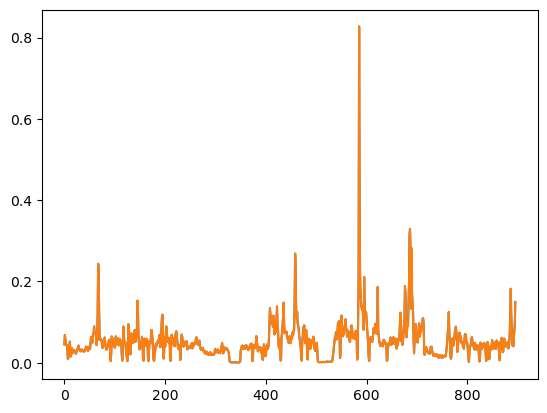

In [20]:
plt.plot(out_zarr[:,0])
plt.plot(out[0,:,0]) #yeah they are the same

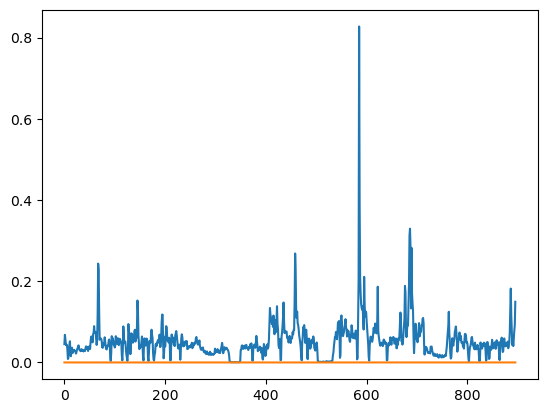

In [21]:
plt.plot(out_zarr[:,0])
#and now plot difference
plt.plot(out_zarr[:,0]-out[0,:,0]) #yeah they are the same

In [22]:
#so we can use the out zarr value to compare

#now let's load in the model the classic way and then test it like that??

#now the final test is calculating spearman correlation, let's make sure this is correct
zarr_open.tree()

/
├── corrs (1937, 674) float32
└── evals (1937, 896, 674) float16

(896, 674)
(896, 674)


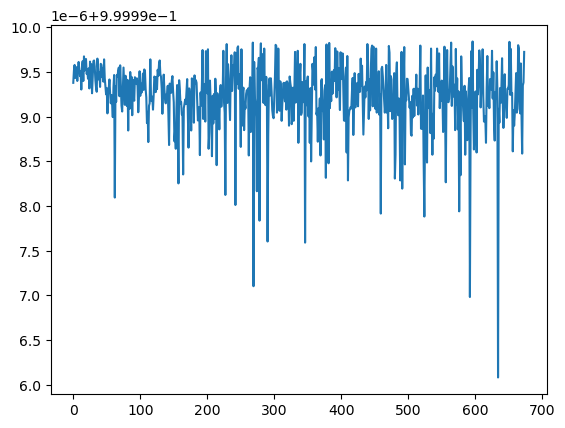

In [24]:
from scipy.stats import spearmanr
spearmans = np.zeros(674)
out_zarr = zarr_open['evals'][0]
print(out_zarr.shape)
print(out[0].shape)
#now do the spearman
for i in range(674):
    corr = spearmanr(out_zarr[:,i], out[0,:,i])
    spearmans[i] = corr.correlation if not np.isnan(corr.correlation) else 0.0 #basically sets it to 0 if nan!
plt.plot(spearmans)

In [25]:
#and let's get the saved spearmans
spearmans_zarr = zarr_open['corrs'][0]
spearmans_zarr.shape

(674,)

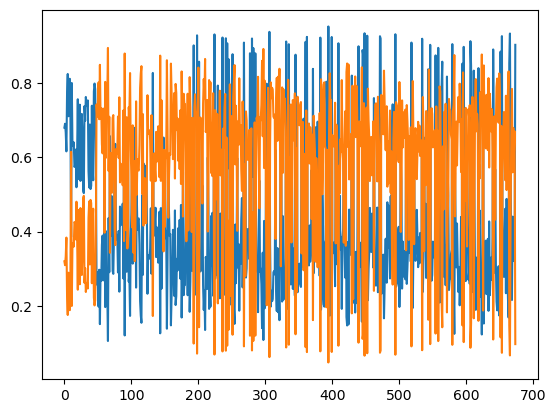

In [28]:
plt.plot(spearmans_zarr)
plt.plot(spearmans-spearmans_zarr) #this is not good since there's clealryy such a huge difference?

In [29]:
#wait we calculated the wrong correlations...
spearmans.min()
#correlated the 2 identical things with each other!! not model output but label

0.9999960796352857

(896, 674)
(896, 674)
(896, 674)


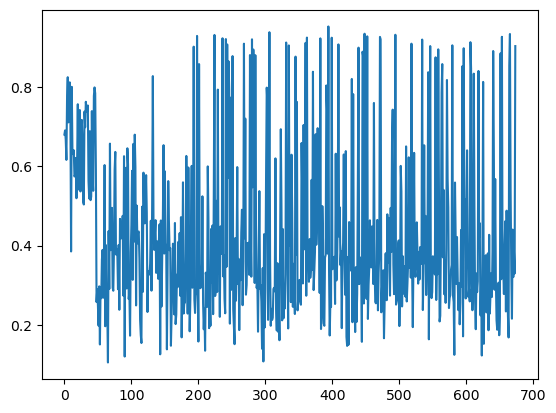

In [33]:
data,label = evals.dataset[0]
label = label.numpy() #just because it's now a numpy array we can calculate the correlation of

spearmans = np.zeros(674)
# out_zarr = zarr_open['evals'][0]
print(out_zarr.shape)
print(out[0].shape)
print(label.shape)
#now do the spearman
for i in range(674):
    corr = spearmanr(label[:,i], out[0,:,i])
    spearmans[i] = corr.correlation if not np.isnan(corr.correlation) else 0.0 #basically sets it to 0 if nan!
plt.plot(spearmans)

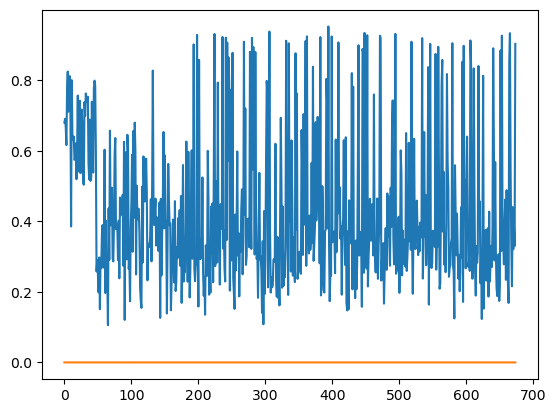

In [34]:
plt.plot(spearmans)
plt.plot(spearmans-spearmans_zarr) #this is good to at least show that what we calculated with zarr makes sense!!

In [35]:
#now let's check the model details and see if it makes sense
evals.backbone #yeah the embeddings look correct...

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): Transpose()
      )
      (layers): ModuleList(
        (0-15): 16 x Block(
          (norm): RMSNorm()
          (mixer): BiMambaWrapper(
            (mamba_fwd): Mamba(
              (in_proj): Linear(in_features=512, out_features=2048, bias=False)
              (conv1d): Conv1d(1024, 1024, kernel_size=(4,), stride=(1,), padding=(3,), groups=1024)
              (act): SiLU()
              (x_proj): Linear(in_features=1024, out_features=64, bias=False)
              (dt_proj): Linear(in_features=32, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=512, bias=False)
            )
            (mamba_rev): Mamba(
              (in_proj): Linear(in_features=512, out_features=2048, bias=False)
              (conv1d): Conv1d(1024, 1024, kernel_size=(4,), stride=(1,), padding=(3,), groups=1024)
  

In [36]:
evals.decoder

EnformerDecoder(
  (output_transform): Linear(in_features=512, out_features=674, bias=True)
  (pool): AvgPool1d(kernel_size=(128,), stride=(128,), padding=(0,))
  (softplus): Softplus(beta=1, threshold=20)
)

In [37]:
#using diff checker to check the difference in configs
#the biggest one is the dataset
type(evals.dataset)
#clealry is gpn msa dataset, and I believe correct args to it, so that's fine

src.dataloaders.datasets.GPNMSA_dataset.GPNMSADataset

In [38]:
#wait I realized in the gpn msa dataset, we do one hot encoding afterwards, which means for evaluating would actually change things? but then that seems fine...
#oh we never used the evaluate functionality I guess, since we wanted to save to zarr, could make this a class option that would speed things up tho
#but that's besides the point, now we have loaded the data the same, so this seems to not be the issue because output makes sense and input is onehot

#we could manually verify that the human sequence at least is correct, but I don't think that's the issue
#the next key issue is that we do rc augmentation. Perhaps that's fine for trainign but worse for evaluation?
#do we do rc aug for the cnn model? That is actually a keyy difference between the models. LEt's turn rc aug off and see what happens
#then the big difference could be due to us doing rc aug vs not. at least duringeval let's turn it off, let's manually run the evaluation not save it but keep in memory, then 

3

# modified code to set rc_aug to false

In [1]:
#first make it so we only see gpu 1
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#now let's evaluate it
import pandas as pd
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
import evals.evals_utils_enformer as e
import torch
import zarr
from tqdm import tqdm

output_dir = 'outputs/2025-02-05/12-33-11-311701'
ckpt_path = f'/data1/lesliec/sarthak/caduceus/{output_dir}/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path, dataset_class='GPNMSA')
out = evals.dataset[0]

out = evals.evaluate(batch_size=2)

base_path: /data1/lesliec/sarthak/
674
100%|██████████| 969/969 [1:13:13<00:00,  4.53s/it]


 52%|█████▏    | 505/969 [38:09<37:28,  4.85s/it]  

In [2]:
out.shape

(1937, 896, 674)

In [5]:
data,label = evals.dataset[0]
label.shape

torch.Size([896, 674])

In [ ]:
#now let's correlate it and see. Obviously if we do reverse complement, what will happen is we will predict the reverse direction
#so that would obviously be wrong, let's see what happens if we solve the rc augmentation!
#that would obviously explain the issue with the bimodality where half is around 0, it was obviously wrong, let's see what happens if we do this

from scipy.stats import spearmanr
import numpy as np

#let's now calculate the correlation then get the mean, then we can overwrite it by modifying the evaluate and update the class to save in zarr!

corrs = np.zeros((out.shape[0], 674))
for i in tqdm(range(out.shape[0])):
    data,label = evals.dataset[i]
    label = label.numpy() #just because it's now a numpy array we can calculate the correlation of
    for j in range(out.shape[2]):
        corr = spearmanr(out[i,:,j], label[:,j])
        corrs[i,j] = corr.correlation if not np.isnan(corr.correlation) else 0.0

 26%|██▌       | 501/1937 [02:07<06:04,  3.94it/s]


KeyboardInterrupt: 

In [6]:
#now let's correlate it and see. Obviously if we do reverse complement, what will happen is we will predict the reverse direction
#so that would obviously be wrong, let's see what happens if we solve the rc augmentation!
#that would obviously explain the issue with the bimodality where half is around 0, it was obviously wrong, let's see what happens if we do this

from scipy.stats import spearmanr
import numpy as np

#let's now calculate the correlation then get the mean, then we can overwrite it by modifying the evaluate and update the class to save in zarr!

corrs = np.zeros((out.shape[0], 674))
for i in tqdm(range(out.shape[0])):
    data,label = evals.dataset[i]
    label = label.numpy() #just because it's now a numpy array we can calculate the correlation of
    for j in range(out.shape[2]):
        corr = spearmanr(out[i,:,j], label[:,j])
        corrs[i,j] = corr.correlation if not np.isnan(corr.correlation) else 0.0

 65%|██████▍   | 1254/1937 [26:16<13:58,  1.23s/it]/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
 65%|██████▍   | 1258/1937 [26:21<13:50,  1.22s/it]/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
 90%|████████▉ | 1736/1937 [37:11<04:18,  1.29s/it]/data1/lesliec/sarthak/caduceus/.pixi/envs/default/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|██████████| 1937/1937 [41:26<00:00,  1.28s/it]


In [7]:
corrs.mean()
#this is still so low...

0.2367429125698302

<Axes: >

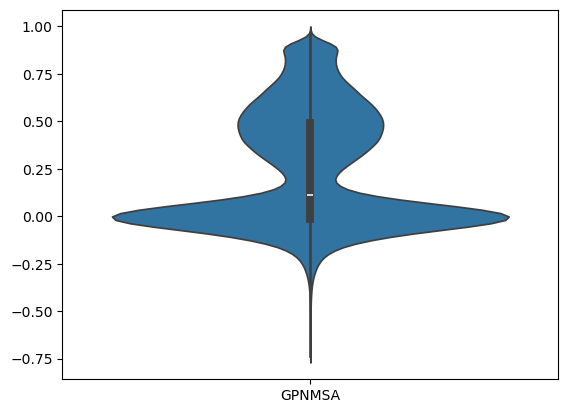

In [8]:
#let's see the violin plot again
import seaborn as sns
#do a violin plot with corrs.flatten()

data = corrs.flatten()
groups = ['GPNMSA'] * len(data)  # Store corresponding group names

#and now plot it
sns.violinplot(x=groups, y=data)

In [ ]:
#my guess is we're still somehow doing rc aug! but this isn't changing the label

#oh wait of course, the label itself is doing rc aug!!!!! So one of them is still randomly flipping, so still 50% chance
#let's make it so rc aug is definitely false in the evals class!!!

# redo

In [1]:
#first make it so we only see gpu 1
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#now let's evaluate it
import pandas as pd
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
import evals.evals_utils_enformer as e
import torch
import zarr
from tqdm import tqdm

output_dir = 'outputs/2025-02-05/12-33-11-311701'
ckpt_path = f'/data1/lesliec/sarthak/caduceus/{output_dir}/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path, dataset_class='GPNMSA')
out = evals.dataset[0]
print(evals.dataset_args)

out = evals.evaluate(batch_size=2)

from scipy.stats import spearmanr
import numpy as np

#let's now calculate the correlation then get the mean, then we can overwrite it by modifying the evaluate and update the class to save in zarr!

corrs = np.zeros((out.shape[0], 674))
for i in tqdm(range(out.shape[0])):
    data,label = evals.dataset[i]
    label = label.numpy() #just because it's now a numpy array we can calculate the correlation of
    for j in range(out.shape[2]):
        corr = spearmanr(out[i,:,j], label[:,j])
        corrs[i,j] = corr.correlation if not np.isnan(corr.correlation) else 0.0

base_path: /data1/lesliec/sarthak/
674
{'max_length': 196608, 'pad_max_length': None, 'rc_aug': False, 'd_output': 674, 'return_CAGE': False, 'kmer_len': None, 'cell_type': 'DNase', 'one_hot': True, 'pool': 128, 'msa_path': None, 'split': 'test'}


  2%|▏         | 17/969 [01:22<1:17:10,  4.86s/it]


KeyboardInterrupt: 

In [3]:
#ran it using nohup
#let's test some other things
import numpy as np
a = np.zeros((3,2,3,2,3))
print(a.shape)
b = np.zeros((*a.shape))
b.shape

SyntaxError: cannot use starred expression here (4042965771.py, line 6)

In [7]:
b = np.zeros((1, *a.shape)) #if combined with other elements can unpack it!!
b.shape

(1, 3, 2, 3, 2, 3)

In [12]:
#and final tests to make it work automatically!
a = {'1': 1, '2': 2}
b = a
b['3'] = 3
print(a)
b = a.copy()
b['4'] = 4
print(a)
print(b)

{'1': 1, '2': 2, '3': 3}
{'1': 1, '2': 2, '3': 3}
{'1': 1, '2': 2, '3': 3, '4': 4}


In [1]:
#I think we have a working one, let's restart the kernel and test it
#set my gpu to 1
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import evals.evals_utils_enformer as e
output_dir = 'outputs/2025-02-05/12-33-11-311701'
ckpt_path = f'/data1/lesliec/sarthak/caduceus/{output_dir}/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path, dataset_class='GPNMSA')
zarr_name = '/data1/lesliec/sarthak/data/borzoi/model_outputs/gpnmsa_basic_ohe_2.zarr'

base_path: /data1/lesliec/sarthak/
674


In [ ]:
evals.evaluate_zarr(zarr_name)

In [2]:
data,label = evals.dataset[0]
label.shape #so if it's 896 xx 674, we need to do the axis of column 0

torch.Size([896, 674])

In [2]:
#and if that works, we run the correlations!
evals.correlate(zarr_name, 0)
#seems to work just fine!!

correlating model as is
corr Array already exists


  0%|          | 7/1937 [00:10<45:59,  1.43s/it]


KeyboardInterrupt: 

In [3]:
#ok now we can submit these as background jobs!!

#let's also test it for the non ohe data!

output_dir = 'outputs/2025-02-05/12-33-11-305656'
ckpt_path = f'/data1/lesliec/sarthak/caduceus/{output_dir}/checkpoints/last.ckpt'
evals = e.Evals(ckpt_path, dataset_class='GPNMSA')
zarr_name = '/data1/lesliec/sarthak/data/borzoi/model_outputs/gpnmsa_basic_cnn_2.zarr'

evals.evaluate_zarr(zarr_name)

674
eval Array already exists


  1%|          | 2/243 [00:41<1:23:28, 20.78s/it]


KeyboardInterrupt: 

In [4]:
evals.correlate(zarr_name, 0)

correlating model as is
corr Array already exists


  0%|          | 4/1937 [00:07<1:00:08,  1.87s/it]


KeyboardInterrupt: 

In [1]:
#and it works, so we'll let them evaluate then recreate th eplot, then we are done with the file!
#ok they should be done

import zarr
zarr_name = '/data1/lesliec/sarthak/data/borzoi/model_outputs/gpnmsa_basic_ohe_2.zarr'
zarr_open = zarr.open(zarr_name, mode='r')
print(zarr_open.tree())

/
├── corrs (1937, 674) float32
└── evals (1937, 896, 674) float16

In [3]:
zarr_open['corrs'][:].mean()

0.51935565

In [4]:
#and for the other one
zarr_name = '/data1/lesliec/sarthak/data/borzoi/model_outputs/gpnmsa_basic_cnn_2.zarr'
zarr_open = zarr.open(zarr_name, mode='r')
zarr_open['corrs'][:].mean()

0.48677504

In [5]:
# this means we can remake the plot!!

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
main_path = '/data1/lesliec/sarthak/data/borzoi/model_outputs/'
files = os.listdir(main_path)
files

['Enformer_cnn_128bp.zarr',
 'Enformer_cnn_32bp.zarr',
 'Enformer_cnn_1bp.zarr',
 'gpnmsa_basic_ohe_2.zarr',
 'Enformer_cnn_128bp_524k_2.zarr',
 'Enformer_cnn_8bp.zarr',
 'gpnmsa_basic_cnn_2.zarr',
 'Enformer_cnn_128bp_393k_2.zarr']

/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_128bp.zarr
/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_128bp_393k_2.zarr
/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_128bp_524k_2.zarr
/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_1bp.zarr
/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_32bp.zarr
/data1/lesliec/sarthak/data/borzoi/model_outputs/Enformer_cnn_8bp.zarr
/data1/lesliec/sarthak/data/borzoi/model_outputs/gpnmsa_basic_cnn_2.zarr
/data1/lesliec/sarthak/data/borzoi/model_outputs/gpnmsa_basic_ohe_2.zarr


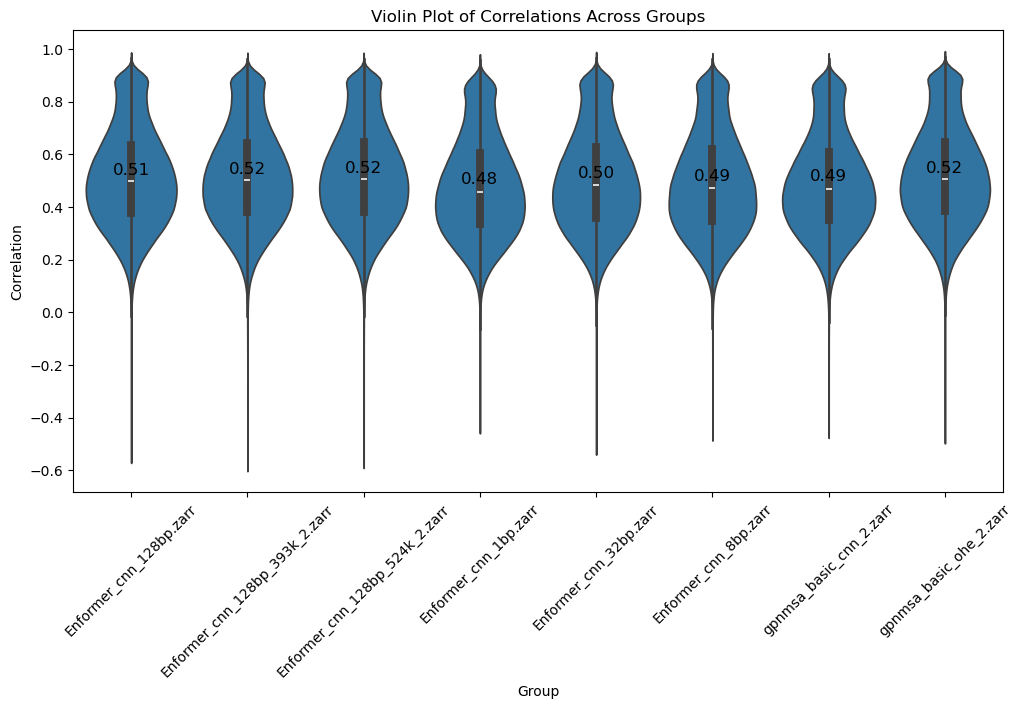

In [15]:
#now  loop through them and plot them all!
data_list = []  # Store all data points
groups_list = []  # Store corresponding group names
mean_vals = []
for file in sorted(files):
    file_path = main_path+file
    print(file_path)
    zarr_open = zarr.open(file_path, mode='r')
    #now append the corrs.flatten to the list
    flatten_data = zarr_open['corrs'][:].flatten()
    mean_vals.append(flatten_data.mean())
    data_list.extend(flatten_data)
    groups_list.extend([file] * len(flatten_data))

df = pd.DataFrame({"Correlation": data_list, "Group": groups_list})

# Plot the violin plot
# ax,fig = plt.subplots(figsize=(12, 6))
plt.figure(figsize=(12, 6))
sns.violinplot(x="Group", y="Correlation", data=df)

# Improve readability
plt.xticks(rotation=45)  # Rotate labels if necessary
plt.title("Violin Plot of Correlations Across Groups")
plt.ylabel("Correlation")
plt.xlabel("Group")

for i in range(len(files)):
    mean_value = mean_vals[i]
    plt.text(i, mean_value, f"{mean_value:.2f}", ha="center", va="bottom", fontsize=12, color="black")

plt.show()


In [10]:
df

,Correlation,Group
0,0.638120,Enformer_cnn_128bp.zarr
1,0.664416,Enformer_cnn_128bp.zarr
2,0.680392,Enformer_cnn_128bp.zarr
3,0.579735,Enformer_cnn_128bp.zarr
4,0.753705,Enformer_cnn_128bp.zarr
...,...,...
10444299,0.556718,Enformer_cnn_128bp_393k_2.zarr
10444300,0.415375,Enformer_cnn_128bp_393k_2.zarr
10444301,0.454904,Enformer_cnn_128bp_393k_2.zarr
10444302,0.630061,Enformer_cnn_128bp_393k_2.zarr
